In [1]:
import stadiffuser.utils as sutils
import warnings
import stadiffuser.utils as stutils
from _utils import *
warnings.filterwarnings("ignore")
sns.set_theme(context="paper", style="ticks", font_scale=1.5)
os.environ["R_HOME"] = r"D:\Program Files\R\R-4.0.3"
warnings.filterwarnings("ignore")
figure_fmt = "../output/App2-HPC/rep{}/_figures"
output_fmt = "../output/App2-HPC/rep{}"
device = torch.device("cuda:0")

method_palette = {
    'splatter':  '#8A98B8',  # Blue
    'kersplatter': '#B5BDD2',  # Lighter blue
    'zinb_spatial': "#EBAB71",  # coral
    'SRT_domain':  '#8CCF87',  # Green
    'scDesign_label': '#C0AFE2',  # Purple
    'stadiff': '#EA6666',  #coral
    "stadiff_label": "#CF4144", #lighter red
}


class RCTDDataset:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self._adata = None
        self._read_data()

    def _read_data(self):
        adata = sc.read_mtx(os.path.join(self.data_dir, "counts.mtx")).T
        adata.obs_names = pd.read_csv(os.path.join(self.data_dir, "obs_names.csv"), index_col=False).iloc[:, 0]
        adata.var_names = pd.read_csv(os.path.join(self.data_dir, "gene_names.csv"), index_col=False).iloc[:, 0]
        adata.obs = pd.read_csv(os.path.join(self.data_dir, "resutls_df.csv"), index_col=0)
        coord = pd.read_csv(os.path.join(self.data_dir, "coord.csv"), index_col=0)
        adata.obsm["spatial"] = coord.iloc[:, :2].values
        self._adata = adata

    @property
    def adata(self):
        return self._adata

# Preprocessing data and save h5ad

In [2]:
# load coord
replicate = 3
data_dir = "E:\Datasets\J20-mouse\\rep{}".format(replicate)
figure_dir = figure_fmt.format(replicate)
output_dir = output_fmt.format(replicate)
rctd = RCTDDataset(data_dir.format(replicate))
adata = rctd.adata
adata = adata[adata.obs["spot_class"] != "reject", :]
rare_celltypes = adata.obs["first_type"].value_counts() < 100
rare_celltypes = rare_celltypes.index[rare_celltypes.values]
adata = adata[~adata.obs["first_type"].isin(rare_celltypes)]
adata_raw = adata.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor="seurat_v3")
remained_genes = adata.var["highly_variable"].values
adata_raw = adata_raw[:, remained_genes]
adata = adata[:, remained_genes]
adata = sutils.cal_spatial_net2D(adata, rad_cutoff=30, use_obsm="spatial")
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
# save the adata to output_dir
# remove spot that has no neighbors in "spatial_net"
# "spatial_net" is a dataframe with columns "Cell1", "Cell2", "Distance" and "EdgeType"
# "Cell1" and "Cell2" are the index of adata.obs
spatial_net = adata.uns["spatial_net"]
valid_spots = np.unique(spatial_net[["Cell1", "Cell2"]].values)
adata = adata[adata.obs_names.isin(valid_spots), :]
adata_raw = adata_raw[adata_raw.obs_names.isin(valid_spots), :]
# Re-run the calculation of spatial network
adata = sutils.cal_spatial_net2D(adata, rad_cutoff=30, use_obsm="spatial")
adata.write_h5ad(os.path.join(output_dir, "adata_processed.h5ad"))
adata_raw.write_h5ad(os.path.join(output_dir, "adata_raw.h5ad"))

------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 91360 edges, 15522 cells, 5.8858 neighbors per cell on average.
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 91360 edges, 15397 cells, 5.9336 neighbors per cell on average.


In [33]:
rep_ids = [1, 2, 3, 4]
used_genes = pd.read_csv(os.path.join(output_dir, "..", "used_genes.csv"), index_col=0)
used_genes = used_genes.index.tolist()
for rep_id in rep_ids:
    # load adata
    output_dir = output_fmt.format(rep_id)
    adata = sc.read_h5ad(os.path.join(output_dir, "adata_processed.h5ad"))
    adata_raw = sc.read_h5ad(os.path.join(output_dir, "adata_raw.h5ad"))
    adata = adata[:, used_genes]
    adata_raw = adata_raw[:, used_genes]
    adata.write_h5ad(os.path.join(output_dir, "adata_processed.h5ad"))
    adata_raw.write_h5ad(os.path.join(output_dir, "adata_raw.h5ad"))

In [2]:
# load processed adata
rep_ids = [1, 2, 3, 4]
adata_list = [sc.read_h5ad(os.path.join(output_fmt.format(rep_id), "adata_processed.h5ad")) for rep_id in rep_ids]

In [3]:
for adata in adata_list:
    print(adata.shape)

(12918, 2455)
(10998, 2455)
(15397, 2455)
(16800, 2455)


In [4]:
12918 + 10998

23916

# Single slice analysis (rep1) and multiple slices analysis (rep1 and rep2)

first_type
Astrocyte                4796
Oligodendrocyte          2567
Denate                   1389
CA3                      1042
CA1                       985
Interneuron               753
Entorihinal               559
Microglia_Macrophages     390
Endothelial_Tip           335
Polydendrocyte            102
Name: count, dtype: int64

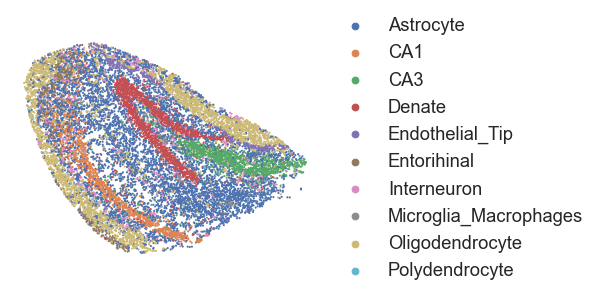

In [3]:
rep_id = 1
output_dir = output_fmt.format(rep_id)
figure_dir = figure_fmt.format(rep_id)
adata = sc.read_h5ad(os.path.join(output_dir, "adata_processed.h5ad"))
adata_raw = sc.read_h5ad(os.path.join(output_dir, "adata_raw.h5ad"))
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sc.pl.embedding(adata, basis="spatial", color="first_type", title="", show=False, ax=ax, frameon=False)
# sc.pl.embedding(adata, basis="spatial", color="first_type", title="", show=False, ax=ax, frameon=False, legend_loc="none")
# set xlabel and ylabel, remove the title
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("")
adata.obs["first_type"].value_counts()
# load autoencoder

## Simulate from single slice STADiffuser model

In [9]:
n_rep = 5
cond_name = "first_type"
autoencoder = torch.load(os.path.join(output_dir, "autoencoder_attn2.pth"), map_location="cpu")
new_spatial = adata.obsm["spatial"].copy()
new_spatial = stutils.quantize_coordination(new_spatial, methods=[("division", 60), ("division", 60)])
adata.obsm["new_spatial"] = new_spatial
denoiser = torch.load(os.path.join(output_dir, "denoiser_first_type.pth"), map_location="cpu")
adata_real_recon = pipeline.get_recon(adata.copy(), autoencoder, device=device, apply_normalize=False)
normalizer = stutils.MinMaxNormalize(adata_real_recon.obsm["latent"], dim=0)
num_class_embeds = len(np.unique(adata.obs[cond_name]))
class_dict = dict(zip(np.unique(adata.obs[cond_name]), range(num_class_embeds)))
adata.obs["encoded_label"] = adata.obs[cond_name].map(class_dict)

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.016666666666666666, mean deviation: 0.25101163750838623, pearson correlation: 0.9997352469329742
Quantize 1th dimension of spatial coordinates to 0.016666666666666666, mean deviation: 0.24806613510863393, pearson correlation: 0.9997342240432965


In [ ]:
for i in range(1, 1 + n_rep):
    stadiff_sim = pipeline.simulate(denoiser, autoencoder, device=device, use_net="spatial_net",
                                    ref_data=adata, spatial_coord=adata.obsm["new_spatial"],
                                    labels = adata.obs["encoded_label"].to_numpy(),
                                    seed=i, normarlizer=normalizer)
    stadiff_sim.write_h5ad("{}/stadiff_label_{}.h5ad".format(output_dir, i))

## Simulate from multiple slices STADiffuser model

In [10]:
output_dir = output_fmt.format("1_2")
adata_slice1 = sc.read_h5ad(os.path.join(output_dir, "adata_slice1.h5ad"))
autoencoder_mul = torch.load(os.path.join(output_dir, "autoencoder_aligned.pth"), map_location="cpu")
denoiser_mul = torch.load(os.path.join(output_dir, "denoiser_first_type.pth"), map_location="cpu")
adata_real_recon_mul = pipeline.get_recon(adata_slice1, autoencoder_mul, device=device, apply_normalize=False)
normalizer_mul = stutils.MinMaxNormalize(adata_real_recon_mul.obsm["latent"], dim=0)
data = pipeline.prepare_dataset(adata, use_net="spatial_net", use_spatial="new_spatial", device="cpu")
adata_real_recon_mul

AnnData object with n_obs × n_vars = 12918 × 2455
    obs: 'spot_class', 'first_type', 'second_type', 'first_class', 'second_class', 'min_score', 'singlet_score', 'conv_all', 'conv_doublet'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'first_type_colors', 'hvg', 'log1p', 'spatial_net', 'edge_list'
    obsm: 'spatial', 'latent'

In [210]:
data = pipeline.prepare_dataset(adata, use_net="spatial_net", use_spatial="new_spatial", device="cpu")
for i in range(1, 1 + n_rep):
    stadiff_sim = pipeline.simulate(denoiser_mul, autoencoder_mul, device=device, use_net="spatial_net",
                                    ref_data=adata, spatial_coord=adata.obsm["new_spatial"],
                                    labels = adata.obs["encoded_label"].to_numpy(),
                                    seed=i, normarlizer=normalizer_mul)
    stadiff_sim.write_h5ad("{}/stadiff_label_{}.h5ad".format(output_dir, i))

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

## Bechmark the performance of the compared methods


In [72]:
from _utils import compute_sim_perf
output_dir_single = output_fmt.format("1")
comp_methods = ["splatter", "kersplatter", "zinb_spatial",  "scDesign", "SRT_domain", "stadiff_label"]
comp_sim_dict = dict()
for comp_method in comp_methods:
    adata_list = [sc.read_h5ad("{}/full_sim/{}_{}.h5ad".format(output_dir_single, comp_method, seed + 1)) for seed in range(n_rep)]
    comp_sim_dict[comp_method] = adata_list
stadiff_mul_list = [sc.read_h5ad("{}/stadiff_label_{}.h5ad".format(output_dir, seed + 1)) for seed in range(n_rep)]
adata_raw.uns["spatial_net"] = adata.uns["spatial_net"].copy()
# adata_raw.X = adata_raw.X.toarray()

In [73]:
comp_sim_dict["stadiff_mul"] = stadiff_mul_list

In [238]:
comp_perf_dict = compute_perf_dict(comp_sim_dict, comp_methods, autoencoder, adata_raw, adata_real_recon, device=device)

==== splatter ====
==== kersplatter ====
==== zinb_spatial ====
==== scDesign ====
==== SRT_domain ====
==== stadiff_label ====


In [239]:
mul_sim_dict = {"stadiff_label": stadiff_mul_list}
comp_perf_dict_mul = compute_perf_dict(mul_sim_dict, ["stadiff_label"], autoencoder_mul, adata_raw, adata_real_recon_mul, device=device)

==== stadiff_label ====


In [67]:
mul_sim_dict

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 mul_sim_dict                                                                                 │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'mul_sim_dict' is not defined

In [240]:
# load the simulated data with label
gene_corr = dict()
for sim_name in comp_sim_dict:
    sim_adata = comp_sim_dict[sim_name][1].copy()
    sim_adata.uns["spatial_net"] = adata_real_recon.uns["spatial_net"]
    if sim_name == "stadiff_label" or sim_name == "stadiff":
        sim_adata_recon = sim_adata
    else:
        sim_adata.obs_names = adata.obs_names
        sim_adata.var_names = adata.var_names
        sim_adata.X = sim_adata.X.toarray()
        sim_adata.obsm["spatial"] = adata.obsm["spatial"]
        sim_adata_recon = pipeline.get_recon(sim_adata, autoencoder, device=device, use_net="spatial_net")
    gene_corr[sim_name] = metrics.compute_corr(sim_adata_recon, adata_real_recon, dim="gene")

In [241]:
sim_adata_reocn = stadiff_mul_list[0].copy()
gene_corr["stadiff_mul"] = metrics.compute_corr(sim_adata_recon, adata_real_recon_mul, dim="gene")

### Gene correlation violin plot

In [8]:
method_palette = {
    'splatter':  '#909AB2',  # Blue
    'kersplatter': '#B9BFCE',  # Lighter blue
    'zinb_spatial': "#DCAC80",  # coral
    'SRT_domain':  '#94C690',  # Green
    'scDesign': '#C2B5DC',  # Purple
    'stadiff': '#D37676',  #red
    "stadiff_label": "#D37676", #lighter red  “#fb9a99”
    "stadiff_mul": "#D37676"
}

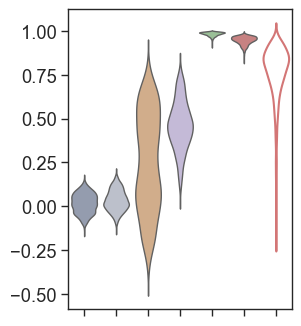

In [247]:
gene_corr_df = pd.DataFrame(gene_corr)
plot_methods = ["splatter", "kersplatter", "zinb_spatial",  "scDesign", "SRT_domain", "stadiff_label", "stadiff_mul"]
gene_corr_df = gene_corr_df[plot_methods].melt(var_name="method", value_name="correlation")
# plot boxplot for gene correlation
fig, ax = plt.subplots(1, 1, figsize=(3.25, 3.5))
# plot violin plot with edge color different and filling is blank
sns.violinplot(x="method", y="correlation", data=gene_corr_df, ax=ax,  scale='width',
               inner=None,
               palette={method: method_palette[method] for method in plot_methods},)
ax.collections[-1].set_facecolor("white")
ax.collections[-1].set_edgecolor(method_palette["stadiff_label"])
# set edge width
ax.collections[-1].set_linewidth(1.5)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
plt.tight_layout()
# save to disk
plt.savefig(os.path.join(figure_dir, "gene_corr_violin.png"), dpi=300)

In [19]:
comp_methods = ["splatter", "kersplatter", "zinb_spatial",  "scDesign", "SRT_domain", "stadiff_label", "stadiff_mul"]
comp_perf_dict_ext = comp_perf_dict.copy()
comp_perf_dict_ext["stadiff_mul"] = comp_perf_dict_mul["stadiff_label"]
perf_df = extract_perf_df(comp_methods , comp_perf_dict_ext)
mul_fid = perf_df.loc["stadiff_mul"]["enhanced_gene_corr"]
mul_div = 1 - perf_df.loc["stadiff_mul"]["pairwise_enhanced_gene_corr"]
fig = plot_performance(perf_df, method_palette, plot_methods=comp_methods[:6])
ax = fig.get_axes()[0]
ax.scatter(mul_div, mul_fid, s=75, marker="D", facecolors="none",
           edgecolors=method_palette["stadiff_mul"], linewidth=1.5)
# set figsize
fig.set_size_inches(3.25, 3.5)
plt.savefig(os.path.join(figure_dir, "enhanced_gene_corr_diversity.png"), dpi=300)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│    1 comp_methods = ["splatter", "kersplatter", "zinb_spatial",  "scDesign", "SRT_domain", "s    │
│ ❱  2 comp_perf_dict_ext = comp_perf_dict.copy()                                                  │
│    3 comp_perf_dict_ext["stadiff_mul"] = comp_perf_dict_mul["stadiff_label"]                     │
│    4 perf_df = extract_perf_df(comp_methods , comp_perf_dict_ext)                                │
│    5 mul_fid = perf_df.loc["stadiff_mul"]["enhanced_gene_corr"]                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'comp_perf_dict' is not defined

## mLSI barplot

In [126]:
for method_name in comp_methods[:6]:
    print("Method: ", method_name)
    comp_perf_dict[method_name]["mLISI"] = []
    adata_sim = comp_sim_dict[method_name][0]
    if method_name == "stadiff_label" or method_name == "stadiff":
        adata_sim_recon = adata_sim
    else:
        adata_sim = adata_sim.copy()
        adata_sim.X = adata_sim.X.toarray()
        adata_sim.uns["spatial_net"] = adata.uns["spatial_net"]
        adata_sim.obsm["spatial"] = adata.obsm["spatial"]
        adata_sim.obs_names = adata.obs_names
        adata_sim_recon = pipeline.get_recon(adata_sim, autoencoder, device=device, use_net="spatial_net")
    comp_perf_dict[method_name]["mLISI"].append(metrics.compute_paired_lisi(adata_sim_recon, adata_real_recon))

Method:  splatter
Method:  kersplatter
Method:  zinb_spatial
Method:  scDesign
Method:  SRT_domain
Method:  stadiff_label


In [219]:
comp_perf_dict["stadiff_mul"] = dict()
comp_perf_dict["stadiff_mul"]["mLISI"] = []
comp_perf_dict["stadiff_mul"]["mLISI"].append(metrics.compute_paired_lisi(stadiff_mul_list[0], adata_real_recon_mul))
np.nanmean(comp_perf_dict["stadiff_mul"]["mLISI"])

1.8620175675139392

['splatter', 'kersplatter', 'zinb_spatial', 'scDesign', 'SRT_domain', 'stadiff_label', 'stadiff_mul']


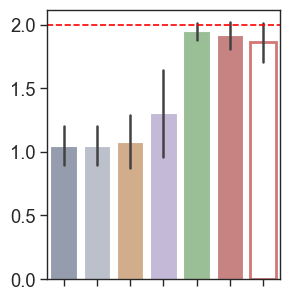

In [229]:
mLISI_df = []
print(plot_methods)
# add column to mLISI_df
for sim_name in plot_methods:
    mLISI_df.append(comp_perf_dict[sim_name]["mLISI"][0])
# convert to dataframe
mLISI_df = np.array(mLISI_df).squeeze().T
mLISI_df = pd.DataFrame(mLISI_df, columns=plot_methods)
fig, ax = plt.subplots(1, 1, figsize=(3, 3.5))
bar = sns.barplot(data=mLISI_df, ax=ax,
            palette={method: method_palette[method] for method in plot_methods}, ci="sd")
# set a horizontal line at 2
ax.axhline(2, color="red", linestyle="--")
# set x label to empty and x axis to empty
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
patch = ax.patches
patch[-1].set_facecolor("white")
patch[-1].set_edgecolor(method_palette["stadiff_mul"])
patch[-1].set_linewidth(2)
# save to disk
plt.savefig(os.path.join(figure_dir, "mLISI_barplot.png"), dpi=300)

In [11]:
target_cell_type = "Microglia_Macrophages"
adata_slice1 = sc.read_h5ad(os.path.join(output_dir, "adata_slice1.h5ad"))
adata_slice2 = sc.read_h5ad(os.path.join(output_dir, "adata_slice2.h5ad"))

In [12]:
adata_slice1_recon = pipeline.get_recon(adata_slice1, autoencoder_mul, device=device, use_net="spatial_net", apply_normalize=False)
adata_slice2_recon = pipeline.get_recon(adata_slice2, autoencoder_mul, device=device, use_net="spatial_net", apply_normalize=False)

In [13]:
def _get_adata(ref, latent, X):
    out = ref.copy()
    out.X = X.copy()
    out.obsm["latent"] = latent.copy()
    return out

n_top_genes = 200
target_cell = "Microglia_Macrophages"
cell_names = adata_real_recon.obs_names[adata_real_recon.obs["first_type"] == target_cell].tolist()
neighbors = adata.uns["spatial_net"]
neighbors = neighbors[neighbors["Cell1"].isin(cell_names) | neighbors["Cell2"].isin(cell_names)]
neighbors = set(neighbors.Cell1.tolist() + neighbors.Cell2.tolist())
neighbors =list(neighbors - set(cell_names))
# remove the duplicated cells in cell_names
# set the cell names into three groups: cell_names, neighbors, and others
cell_group = np.array(["others"] * adata_real_recon.n_obs)
cell_group[np.isin(adata_real_recon.obs_names, cell_names)] = "target"
cell_group[np.isin(adata_real_recon.obs_names, neighbors)] = "neighbor"

In [20]:
comp_methods = ["splatter", "kersplatter", "zinb_spatial",  "scDesign", "SRT_domain", "stadiff_label", "stadiff_mul"]
adata_real_recon.uns["log1p"] = dict()
adata_real_recon.uns["log1p"]["base"] = np.e
adata_real_recon_mul.uns["log1p"] = dict()
adata_real_recon_mul.uns["log1p"]["base"] = np.e
method_gene_dict = dict()
for i in range(1, 1 + n_rep):
    print("Using {} simulations".format(i))
    for method_name in comp_methods:
        use_ad_list = []
        if method_name not in method_gene_dict:
            method_gene_dict[method_name] = []
        if method_name == "stadiff_label":
                for ad in comp_sim_dict[method_name][:i]:
                    ad = ad.copy()
                    ad = _get_adata(adata_real_recon, ad.obsm["latent"], ad.X)
                    ad.obs["cell_group"] = cell_group
                    use_ad_list.append(ad)
        elif method_name == "stadiff_mul":
            for ad in stadiff_mul_list[:i]:
                ad = ad.copy()
                ad = _get_adata(adata_real_recon_mul, ad.obsm["latent"], ad.X)
                ad.obs["cell_group"] = cell_group
                use_ad_list.append(ad)
        else:
            for ad in comp_sim_dict[method_name][:i]:
                ad = ad.copy()
                ad.obsm["spatial"] = adata.obsm["spatial"]
                ad.uns["spatial_net"] = adata.uns["spatial_net"]
                ad.obs_names = adata.obs_names
                ad.obs = adata.obs.copy()
                ad.var_names = adata.var_names
                ad.obs["cell_group"] = cell_group
                ad = pipeline.get_recon(ad, autoencoder, device=device, use_net="spatial_net")
                use_ad_list.append(ad)
        print("Method: ", method_name, len(use_ad_list))
        ad_temp = sc.AnnData.concatenate(*use_ad_list)
        sc.tl.rank_genes_groups(ad_temp, groupby="cell_group", method="wilcoxon")
        method_gene_dict[method_name].append(sc.get.rank_genes_groups_df(ad_temp, group="target", pval_cutoff=0.05).names[:n_top_genes].tolist())

Using 1 simulations
Method:  splatter 1
Method:  kersplatter 1
Method:  zinb_spatial 1
Method:  scDesign 1
Method:  SRT_domain 1
Method:  stadiff_label 1
Method:  stadiff_mul 1
Using 2 simulations
Method:  splatter 2
Method:  kersplatter 2
Method:  zinb_spatial 2
Method:  scDesign 2
Method:  SRT_domain 2
Method:  stadiff_label 2
Method:  stadiff_mul 2
Using 3 simulations
Method:  splatter 3
Method:  kersplatter 3
Method:  zinb_spatial 3
Method:  scDesign 3
Method:  SRT_domain 3
Method:  stadiff_label 3
Method:  stadiff_mul 3
Using 4 simulations
Method:  splatter 4
Method:  kersplatter 4
Method:  zinb_spatial 4
Method:  scDesign 4
Method:  SRT_domain 4
Method:  stadiff_label 4
Method:  stadiff_mul 4
Using 5 simulations
Method:  splatter 5
Method:  kersplatter 5
Method:  zinb_spatial 5
Method:  scDesign 5
Method:  SRT_domain 5
Method:  stadiff_label 5
Method:  stadiff_mul 5


In [21]:
consecutive_overlap = dict()
for method in method_gene_dict:
    consecutive_overlap[method] = []
    for i in range(n_rep - 1):
        gene_list1 = set(method_gene_dict[method][i])
        gene_list2 = set(method_gene_dict[method][i + 1])
        overlap = len(gene_list1.intersection(gene_list2))
        consecutive_overlap[method].append(overlap)
consecutive_overlap_df = pd.DataFrame(consecutive_overlap)
# melt the dataframe
consecutive_overlap_df = consecutive_overlap_df.melt(var_name="method", value_name="overlap", ignore_index=False)
consecutive_overlap_df["rep"] = consecutive_overlap_df.index

In [22]:
consecutive_overlap

{'splatter': [0, 0, 0, 23],
 'kersplatter': [0, 0, 0, 0],
 'zinb_spatial': [123, 159, 152, 175],
 'scDesign': [181, 183, 193, 190],
 'SRT_domain': [200, 199, 199, 200],
 'stadiff_label': [199, 199, 199, 199],
 'stadiff_mul': [199, 198, 198, 199]}

[Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')]

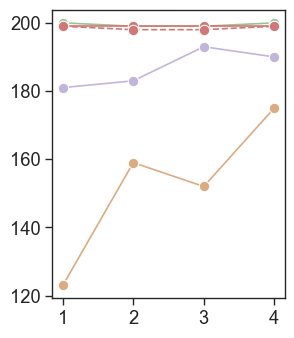

In [23]:
plt.rcParams['lines.markersize'] = 7.5
plot_methods = ["zinb_spatial",  "scDesign", "SRT_domain", "stadiff_label"]
fig, ax = plt.subplots(1, 1, figsize=(3, 3.75))
consecutive_overlap_df_sub = consecutive_overlap_df[consecutive_overlap_df["method"].isin(plot_methods)]
sns.lineplot(data=consecutive_overlap_df_sub, ax=ax,
             x="rep", y="overlap", hue="method",
             palette={method: method_palette[method] for method in plot_methods}, marker="o",
             legend=None,
             linestyle="-")
consecutive_overlap_df_sub = consecutive_overlap_df[consecutive_overlap_df["method"].isin(["stadiff_mul"])]
sns.lineplot(data=consecutive_overlap_df_sub, ax=ax,
             x="rep", y="overlap", color=method_palette["stadiff_label"], marker="o", linestyle="--")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([rep for rep in range(n_rep-1)])
ax.set_xticklabels([rep + 1 for rep in range(n_rep-1)])

In [14]:
real_gene_list = pd.read_csv(os.path.join(output_dir, "..", "gene_list_multi.csv"), index_col=0)
real_gene_list = real_gene_list.index.tolist()[:n_top_genes]
mm_marker_genes = pd.read_csv(os.path.join(output_dir, "..", "MM_cellmarker.csv"), index_col=0)["Cell marker"].tolist()

In [15]:
# read multi gene list
real_overlap = dict()
marker_overlap = dict()
for method in method_gene_dict:
    real_overlap[method] = []
    marker_overlap[method] = []
    for gene_list in method_gene_dict[method]:
        overlap = len(set(real_gene_list).intersection(set(gene_list)))
        real_overlap[method].append(overlap)
        overlap = len(set(mm_marker_genes).intersection(set(gene_list)))
        marker_overlap[method].append(overlap)
real_overlap

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│    1 # read multi gene list                                                                      │
│    2 real_overlap = dict()                                                                       │
│    3 marker_overlap = dict()                                                                     │
│ ❱  4 for method in method_gene_dict:                                                             │
│    5 │   real_overlap[method] = []                                                               │
│    6 │   marker_overlap[method] = []                                                             │
│    7 │   for gene_list in method_gene_dict[method]:                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'method_gene_dict' is not defined

In [357]:
plot_methods

['zinb_spatial', 'scDesign', 'SRT_domain', 'stadiff_label', 'stadiff_mul']

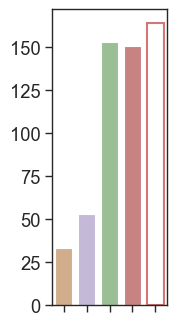

In [379]:
real_overlap_df = pd.DataFrame(real_overlap)
# plot bar plot for index == 0
fig, ax = plt.subplots(1, 1, figsize=(2, 3.5))
real_overlap_df = real_overlap_df.melt(var_name="method", value_name="overlap", ignore_index=False)
real_overlap_df["rep"] = real_overlap_df.index
real_overlap_df_sub = real_overlap_df[real_overlap_df["rep"] == 0]
# only keep the plot_methods
real_overlap_df_sub = real_overlap_df_sub[real_overlap_df_sub["method"].isin(plot_methods + ["stadiff_mul"])]
sns.barplot(data=real_overlap_df_sub, x="method", y="overlap", ax=ax,
            palette={method: method_palette[method] for method in plot_methods + ["stadiff_mul"]}, width=0.75)
# get the set the last bar facecolor to white
patch = ax.patches
patch[-1].set_facecolor("white")
patch[-1].set_edgecolor(method_palette["stadiff_mul"])
patch[-1].set_linewidth(1.5)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
plt.tight_layout()
fig.savefig(os.path.join(figure_dir, "bar_plot_real_gene_overlap.png"), dpi=300)

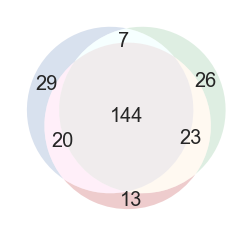

In [375]:
# plot venndiagram with stadiff_label stadiff_mul and SRT_domain genes
from matplotlib_venn import venn3
fig, ax = plt.subplots(1, 1, figsize=(3, 3.5))
venn3([set(real_gene_list), set(method_gene_dict["stadiff_label"][0]), set(method_gene_dict["stadiff_mul"][0])],
      set_labels=None, ax=ax, set_colors = ["#9FB4D5",  "#AED6B7", "#D58183"])
# save to disk
plt.savefig(os.path.join(figure_dir, "venn_gene_real_single_mul.png"), dpi=300)

In [474]:
mul_unique = set(method_gene_dict["stadiff_mul"][0]) - set(method_gene_dict["stadiff_label"][0]).union(set(method_gene_dict["SRT_domain"][0]))
# sort by alphabetical order
mul_unique = sorted(list(mul_unique))

In [475]:
msg = ""
for gene in mul_unique:
    msg += gene + ", "
print(msg[:-2])

Adgre1, Axl, Bin2, Ccl9, Cd63, Cspg4, Fermt3, Fgd2, Gpr183, Higd1b, Igf1, Il10ra, Itgb2, Jam2, Lcp2, Lima1, Ltc4s, Mob1a, Ms4a6c, Plcb3, Prcp, Ptpn18, Rin2, Slc14a1, Slc40a1, St3gal6, Tgfb1, Tnfaip8l2, Ucp2, Vamp8


zinb_spatial
scDesign
SRT_domain
stadiff_label
stadiff_mul


### Load scRNA-seq reference data

In [16]:
# load scRNA-seq reference data
from scipy.stats import ranksums
adata_ref = sc.read_10x_mtx("../dataset/GSM4783652", var_names='gene_symbols', cache=True)
adata_ref = adata_ref[:, adata_ref.var_names.isin(adata.var_names)].copy()
sc.pp.filter_cells(adata_ref, min_genes=200)
sc.pp.log1p(adata_ref)
sc.tl.score_genes(adata_ref, gene_list=real_gene_list, score_name="MM_score")
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

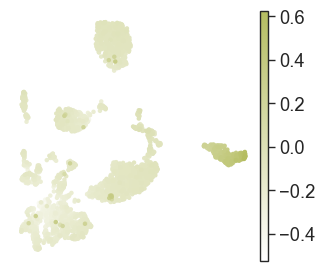

In [155]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#ffffff', '#b5bd61']  # Light gray to #b5bd61
cmap_name = 'light_gray_to_b5bd61'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.25))
# plot umap without colorbar
sc.pl.umap(adata_ref, color="MM_score", title="", show=True, vmax="p99.9", vmin="p0.1",
           cmap=cmap, frameon=False, ax=ax, legend_loc=None)
# save to disk
# fig.savefig(os.path.join(figure_dir, "MM_score_umap.png"), dpi=300)

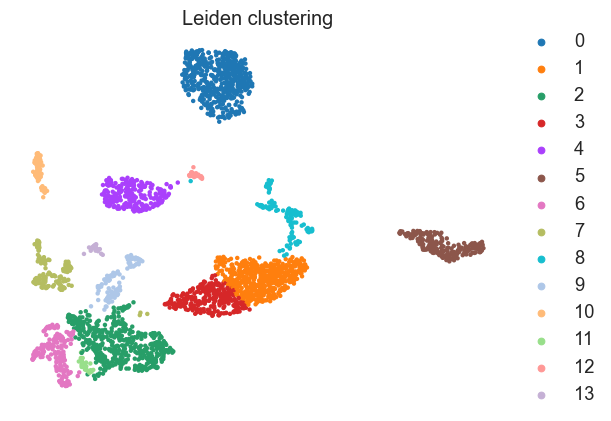

In [156]:
# compute gene score by real_gene_list
# perform leiden clustering
sc.tl.leiden(adata_ref, resolution=0.5)
sc.pl.umap(adata_ref, color="leiden", title="Leiden clustering", show=True, frameon=False)
adata_ref.obs["cell_group"] = "others"
# assign leiden cluster 5 to MM
adata_ref.obs.loc[adata_ref.obs["leiden"] == "5", "cell_group"] = "MM"
adata_ref_magic = sc.external.pp.magic(adata_ref, name_list=None, knn=5, copy=True)

- Axl: Axl is a receptor tyrosine kinase expressed on microglia and macrophages, which has been shown to modulate their activation and response to neuroinflammation. It has been implicated in Alzheimer's disease pathogenesis through its involvement in phagocytosis and inflammatory signaling.

- Bin2 (also known as Bridging Integrator 2): Bin2 is involved in the regulation of microglial phagocytosis and has been associated with Alzheimer's disease risk through its role in modulating amyloid-beta clearance.

- Cd63: This gene encodes a protein involved in the formation of intracellular vesicles, including those related to phagocytosis in microglia and macrophages. It has been implicated in Alzheimer's disease pathology, particularly in the context of lysosomal dysfunction and amyloid-beta processing.

- Ms4a6c: Similar to MS4A6B mentioned earlier, MS4A6C belongs to the MS4A gene family and has been associated with immune responses and inflammation. Its specific role in microglia and macrophages in Alzheimer's disease warrants further investigation.

In [18]:
adata.obs["cell_group"] = cell_group
adata.obs["cell_group"] .value_counts()

cell_group
others    11296
neighb     1232
target      390
Name: count, dtype: int64

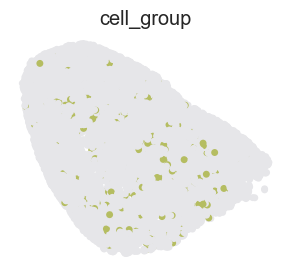

Text(0.5, 1.0, '')

In [19]:
# plot celltype in adata, show microglia and macrophages as vega_scanpy_20[7] other as grey
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
sc.pl.embedding(adata, basis="spatial", color="cell_group", ax=ax, frameon=False,
                palette={"target": "#b5bd61", "neighb": "#E6E6E9", "others": "#E6E6E9"},
                legend_loc="none", size=100)
ax.set_title("")

In [380]:
# spatial
target_gene = "Axl"
plot_methods = ["zinb_spatial",  "scDesign", "SRT_domain", "stadiff_label", "stadiff_mul"]
target_gene_df = []
for method in plot_methods:
    print(method)
    if method == "stadiff_label":
        ad = comp_sim_dict[method][0].copy()
    elif method == "stadiff_mul":
        ad = stadiff_mul_list[0].copy()
    else:
        ad = comp_sim_dict[method][0].copy()
        ad.obs_names = adata.obs_names
        ad.obs = adata.obs.copy()
        ad.obsm = adata.obsm.copy()
        ad.uns = adata.uns.copy()
        ad = pipeline.get_recon(ad, autoencoder, device=device, use_net="spatial_net")
    ad.var_names = adata.var_names
    ad = ad[:, target_gene]
    target_gene_exp = ad[cell_group != "others"].X
    target_gene_df.append(pd.DataFrame({"method": method,
                                        "expression": np.array(target_gene_exp).reshape(-1),
                                        "cell_group": cell_group[cell_group != "others"]}))
ad = adata_real_recon.copy()
ad = ad[:, target_gene]
target_gene_exp = ad[cell_group != "others"].X
target_gene_df.append(pd.DataFrame({"method": "real",
                                    "expression": np.array(target_gene_exp).reshape(-1),
                                    "cell_group": cell_group[cell_group != "others"]}))
# ad = adata_real_recon_mul.copy()
# ad = ad[:, target_gene]
# target_gene_exp = ad[cell_group != "others"].X
# target_gene_df.append(pd.DataFrame({"method": "real_mul",
#                                     "expression": np.array(target_gene_exp).reshape(-1),
#                                     "cell_group": cell_group[cell_group != "others"]}))
target_gene_df = pd.concat(target_gene_df)

zinb_spatial
scDesign
SRT_domain
stadiff_label
stadiff_mul


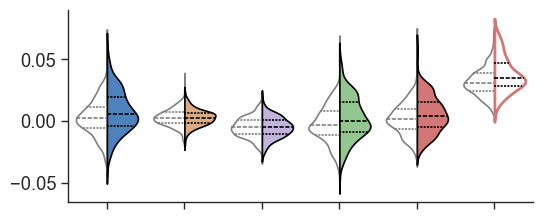

In [381]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
sns.violinplot(data=target_gene_df, x="method", y="expression", hue="cell_group", ax=ax,
               split=True, inner="quart", fill=False, legend=None,
               palette={"target": "black", "neighb": "grey"},
               order=["real", "zinb_spatial",  "scDesign", "SRT_domain", "stadiff_label", "stadiff_mul"],
               scale="width")
# rotate the xticklabels
face_color = ["#4F81BD"] + [method_palette[method] for method in plot_methods]
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
for ind in range(len(ax.collections) - 1):
    # if odd set the edge to white
    if ind % 2 == 0:
        ax.collections[ind].set_facecolor("white")
        ax.collections[ind].set_edgecolor("grey")
    else:
        method_ind = ind // 2
        ax.collections[ind].set_facecolor(face_color[method_ind])
ax.collections[-1].set_facecolor("white")
ax.collections[-1].set_edgecolor(method_palette["stadiff_label"])
ax.collections[-1].set_linewidth(2)
sns.despine()
ax.collections[0].set_facecolor("white")
ax.collections[0].set_edgecolor("grey")
ax.set_xlabel("")
ax.set_xticklabels([])
ax.set_ylabel("")
# save to disk
plt.savefig(os.path.join(figure_dir, "{}_violin.png".format(target_gene)), dpi=300)

Wilcoxon rank sum test p-value: 8.24e-62


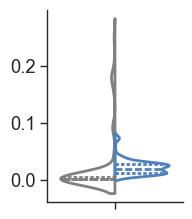

In [382]:
fig, ax = plt.subplots(1, 1, figsize=(1.75, 2.5))
sc_target_gene = adata_ref_magic[:, target_gene].copy().X
sc_gene_exp_df = pd.DataFrame({"expression": sc_target_gene.reshape(-1),
                               "cell_group": adata_ref.obs["cell_group"].tolist()})
sc_gene_exp_df["method"] = "scRNA-seq"
sns.violinplot(data=sc_gene_exp_df, x="method", y="expression", ax=ax, split=True, inner="quart",
               fill=False, hue="cell_group", legend=None, palette={"MM": "#4F81BD", "others": "grey"},  scale="width",
               linewidth=2)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
sns.despine()
# compute wilcoxon rank sum test: MM vs others
MM_exp = sc_gene_exp_df[sc_gene_exp_df["cell_group"] == "MM"]["expression"]
others_exp = sc_gene_exp_df[sc_gene_exp_df["cell_group"] == "others"]["expression"]
_, pval = ranksums(MM_exp, others_exp)
print("Wilcoxon rank sum test p-value: {:.2e}".format(pval))
# save to disk
# plt.savefig(os.path.join(figure_dir, "{}-scRNA-seq_violin.png".format(target_gene)), dpi=300)

splatter Axl


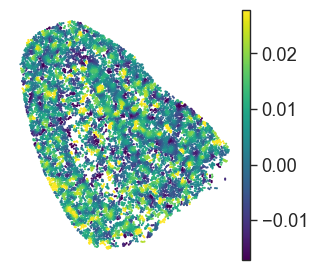

kersplatter Axl


<Figure size 640x480 with 0 Axes>

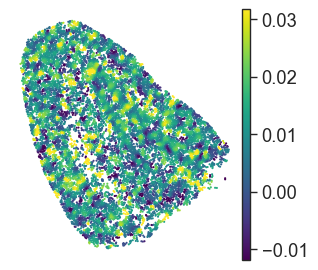

zinb_spatial Axl


<Figure size 640x480 with 0 Axes>

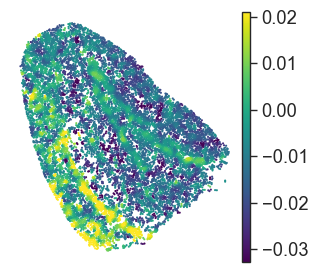

scDesign Axl


<Figure size 640x480 with 0 Axes>

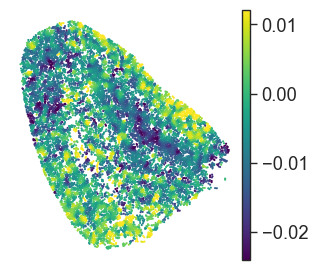

SRT_domain Axl


<Figure size 640x480 with 0 Axes>

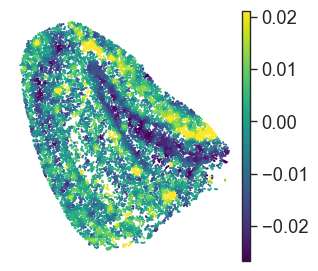

stadiff_label Axl


<Figure size 640x480 with 0 Axes>

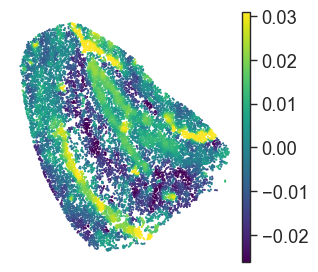

<Figure size 640x480 with 0 Axes>

In [22]:
target_gene = "Axl"
for method in comp_sim_dict:
    print(method, target_gene)
    ad_temp = comp_sim_dict[method][0].copy()
    ad_temp = comp_sim_dict[method][0].copy()
    ad_temp.obsm = adata.obsm.copy()
    ad_temp.uns = adata.uns.copy()
    ad_temp.obsm["ori_spatial"] = adata.obsm["spatial"]
    if method != "stadiff_mul" and method != "stadiff_label":
        ad_temp.obs_names = adata.obs_names.tolist()
        ad_temp.var_names = adata.var_names.tolist()
        ad_temp = pipeline.get_recon(ad_temp, autoencoder, device=device, use_net="spatial_net")
    fig, ax = plt.subplots(1, 1, figsize=(3.25, 3.25))
    sc.pl.embedding(ad_temp, basis="ori_spatial", color=target_gene, title="", show=True,
                    vmax="p2.5", vmin="p97.5", cmap="viridis", frameon=False, ax=ax)
    fig.delaxes(fig.axes[1])
    plt.tight_layout()
    fig.savefig(os.path.join(figure_dir, "{}_{}_spatial.png".format(method, target_gene)), dpi=300)

In [162]:
gene_list = [
    "Adgre1", "Axl", "Bin2", "Ccl9", "Cd63", "Cspg4",
    "Fermt3", "Fgd2", "Gpr183", "Higd1b", "Igf1", "Il10ra",
    "Itgb2", "Jam2", "Lcp2", "Lima1", "Ltc4s", "Mob1a",
    "Ms4a6c", "Plcb3", "Prcp", "Ptpn18", "Rin2", "Slc14a1",
    "Slc40a1", "St3gal6", "Tgfb1", "Tnfaip8l2", "Ucp2", "Vamp8"
]
# check if the gene list in scRNA-seq data is diffrentiall expressed by MM and others
pval_dict = dict()
for gene in adata_ref_magic.var_names:
    sc_target_gene = adata_ref_magic[:, gene].copy().X
    sc_gene_exp_df = pd.DataFrame({"expression": sc_target_gene.reshape(-1),
                                   "cell_group": adata_ref.obs["cell_group"].tolist()})
    MM_exp = sc_gene_exp_df[sc_gene_exp_df["cell_group"] == "MM"]["expression"]
    others_exp = sc_gene_exp_df[sc_gene_exp_df["cell_group"] == "others"]["expression"]
    _, p = ranksums(MM_exp, others_exp)
    pval_dict[gene] = p

In [167]:
pval_df = pd.DataFrame(pval_dict, index=[0])
pval_df = pval_df.T
pval_df.columns = ["pval"]


In [189]:
pval_df["logpval"] = -np.log10(pval_df["pval"] * len(pval_df))

In [206]:
# get the quantlies
pval_df["logpval"].quantile([0.25, 0.5, 0.75])


0.25     36.434555
0.50     73.691072
0.75    109.349727
Name: logpval, dtype: float64

In [192]:
# show gene in gene_list
logpval_gene_list = pval_df.loc[gene_list]
#
logpval_rest = pval_df.copy().drop(gene_list)

In [205]:
logpval_gene_list

pval     logpval
Adgre1     3.574457e-129  125.058689
Axl         4.654433e-22   17.944032
Bin2       3.574457e-129  125.058689
Ccl9       9.945879e-129  124.614256
Cd63        1.417033e-03   -0.539481
Cspg4      5.511897e-101   96.870598
Fermt3     3.574457e-129  125.058689
Fgd2       3.574457e-129  125.058689
Gpr183     3.574457e-129  125.058689
Higd1b      1.201111e-89   85.532316
Igf1        2.476811e-41   37.218006
Il10ra     3.574457e-129  125.058689
Itgb2      3.479048e-128  124.070438
Jam2        4.706349e-78   73.939215
Lcp2       3.574457e-129  125.058689
Lima1       4.804749e-43   38.930228
Ltc4s      2.823672e-124  120.161085
Mob1a       5.873122e-30   25.843030
Ms4a6c     7.243556e-129  124.751947
Plcb3       9.040678e-34   29.655698
Prcp        8.828555e-27   22.666009
Ptpn18     1.093907e-123  119.572918
Rin2        2.271036e-93   89.255675
Slc14a1     4.586391e-77   72.950428
Slc40a1    5.094149e-129  124.904827
St3gal6    8.655210e-128  123.674621
Tgfb1      3.574457e-129  125.058689
Tnfaip8l2  9.844705e-129  124.618696
Ucp2       1.379390e-119  115.472212
Vamp8      5.908657e-104   99.840410

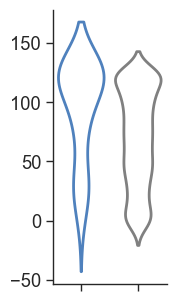

In [217]:
# plot the boxplot of logpval rest vs gene_list
fig, ax = plt.subplots(1, 1, figsize=(2, 3.25))
logvals_cat = pd.concat([logpval_gene_list, logpval_rest])
logvals_cat["gene_list"] = "others"
logvals_cat.loc[gene_list, "gene_list"] = "gene_list"
sns.violinplot(data=logvals_cat, x="gene_list", y="logpval", ax=ax,
               palette={"gene_list": "#4F81BD", "others": "grey"},
               inner=None,
               fill=False, linewidth=2)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(figure_dir, "ms_unique_genes_logpval_violin.png"), dpi=300)

In [194]:
logpval_rest.mean()

pval        0.01824
logpval    69.77117
dtype: float64

In [151]:
from scipy.spatial import cKDTree
target_gene = "Axl"
radius = 15
target_spatial = adata.obsm["spatial"][adata.obs["cell_group"] == "target"]
cutoff_quantile = 1 - len(target_spatial) / adata.shape[0]
tree = cKDTree(target_spatial)
coco_dict = dict()
# get the number of target cells within the radius
for method in comp_sim_dict:
    print(method, target_gene)
    ad_temp = comp_sim_dict[method][0].copy()
    ad_temp = comp_sim_dict[method][0].copy()
    ad_temp.obsm = adata.obsm.copy()
    ad_temp.uns = adata.uns.copy()
    ad_temp.var_names = adata.var_names.tolist()
    ad_temp.obsm["ori_spatial"] = adata.obsm["spatial"]
    if method != "stadiff_mul" and method != "stadiff_label":
        ad_temp.obs_names = adata.obs_names.tolist()
        ad_temp.var_names = adata.var_names.tolist()
        ad_temp = pipeline.get_recon(ad_temp, autoencoder, device=device, use_net="spatial_net")
    cutoff = np.quantile(ad_temp[:, target_gene].X, cutoff_quantile)
    indices = ad_temp[:, target_gene].X > cutoff
    high_spatial = adata.obsm["spatial"][indices.flatten()]
    dist, ind = tree.query(high_spatial, k=1)
    n_target = len(np.unique(ind[dist < radius]))
    print("Method: ", method, "Percentage of target cells within radius: {:.3f}".format(n_target / len(target_spatial)))
    coco_dict[method] = n_target / len(target_spatial)

splatter Axl
Method:  splatter Percentage of target cells within radius: 0.026
kersplatter Axl
Method:  kersplatter Percentage of target cells within radius: 0.031
zinb_spatial Axl
Method:  zinb_spatial Percentage of target cells within radius: 0.010
scDesign Axl
Method:  scDesign Percentage of target cells within radius: 0.028
SRT_domain Axl
Method:  SRT_domain Percentage of target cells within radius: 0.123
stadiff_label Axl
Method:  stadiff_label Percentage of target cells within radius: 0.044
stadiff_mul Axl
Method:  stadiff_mul Percentage of target cells within radius: 0.151


In [110]:
method_palette2 = {
    'splatter':  '#909AB2',  # Blue
    'kersplatter': '#B9BFCE',  # Lighter blue
    'zinb_spatial': "#DCAC80",  # coral
    'SRT_domain':  '#94C690',  # Green
    'scDesign': '#C2B5DC',  # Purple
    'stadiff': '#D37676',  #red
    "stadiff_label": "#D37676", #lighter red  “#fb9a99”
    "stadiff_mul": "#D37676"
}

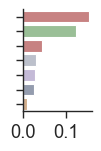

In [152]:
coco_df = pd.DataFrame(coco_dict, index=[0])
# transpose the dataframe
coco_df = coco_df.T
# plot barplot
# reorder coco_df in descending order
coco_df = coco_df.sort_values(by=0, ascending=False)
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(1.25, 1.75))
sns.barplot(data=coco_df, y=coco_df.index, x=0, ax=ax,
            palette=method_palette2, orient="h")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticklabels([])
sns.despine()
# ax.set_xticklabels([])
# save to disk
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, "coco_barplot_{}.png".format(target_gene)),
            dpi=300)


In [295]:
go_res_dict = dict()
for method_name in method_gene_dict:
    gene_list = method_gene_dict[method_name][0]
    # chekc if the gene list is empty
    if len(gene_list) == 0:
        print("No genes are found for method: ", method_name)
        go_res = None
    else:
        go_res = sc.queries.enrich(gene_list, org="mmusculus")
    go_res_dict[method_name] = go_res

No genes are found for method:  splatter


In [387]:
ad_temp = stadiff_mul_list[0]
ad_temp = ad_temp.copy()
ad_temp.obs["cell_group"] = cell_group
ad_temp.uns["log1p"] = dict()
ad_temp.uns["log1p"]["base"] = np.e
sc.tl.rank_genes_groups(ad_temp, groupby="cell_group", method="wilcoxon")
deg_temp = sc.get.rank_genes_groups_df(ad_temp, group="target", pval_cutoff=0.05).head(n=n_top_genes)

In [392]:
deg_temp.loc[deg_temp["names"].isin(["Axl", "Bin2", "Cd63", "Ms4a6c"])]

names     scores  logfoldchanges          pvals      pvals_adj
61     Bin2  22.044411        1.228794  1.080780e-107  4.279541e-106
163     Axl  15.193974        0.493933   3.876838e-52   5.665260e-51
169  Ms4a6c  14.895346        1.124137   3.533517e-50   4.901008e-49
196    Cd63  12.217609        0.619684   2.503394e-34   2.111970e-33

In [347]:
plot_methods = ["zinb_spatial", "scDesign", "SRT_domain", "stadiff_label", "stadiff_mul"]
# get the union of top 10 names
go_name_set = set()
top_n_terms = 15
for method in plot_methods[2:]:
    if go_res_dict[method] is not None:
        go_name_set = go_name_set.union(set(go_res_dict[method].head(n=top_n_terms).name.tolist()))
go_name_list = list(go_name_set)
len(go_name_set)


19

In [348]:
go_df_list = []
for method in plot_methods:
    if go_res_dict[method] is not None:
        go_df = go_res_dict[method]
        go_df = go_df[go_df["name"].isin(go_name_list)]
        go_df["method"] = method
        go_df["-logpval"] = -np.log10(go_df["p_value"])
        go_df_list.append(go_df)
go_df_all = pd.concat(go_df_list)
# sort by -logpval
go_df_all = go_df_all.sort_values(by="-logpval", ascending=False)

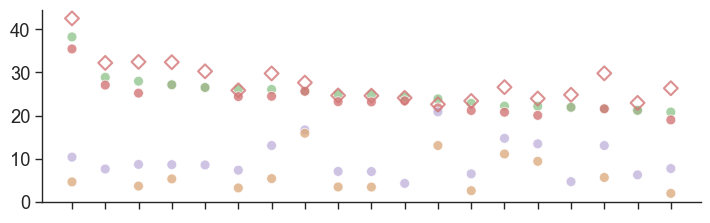

In [349]:
# plot scatter
fig, ax = plt.subplots(1, 1, figsize=(8.5, 2.5))
go_df_mul = go_df_all[go_df_all["method"] == "stadiff_mul"]
go_df_ex_mul = go_df_all[go_df_all["method"] != "stadiff_mul"]
sns.scatterplot(data=go_df_ex_mul, x="name", y="-logpval", hue="method", ax=ax, s=50,
                palette={method: method_palette[method] for method in plot_methods},
                legend=None, alpha=0.8)
ax.scatter(go_df_mul["name"], go_df_mul["-logpval"], s=50, marker="D", facecolors="none",
           edgecolors=method_palette["stadiff_mul"], linewidth=1.5, alpha=0.8)
# set xticklabels to empty
# rotate
xtick_labels = [label.get_text() for label in ax.get_xticklabels()]
ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_ylabel("")
sns.despine()
# save to disk
plt.savefig(os.path.join(figure_dir, "union_top_20_go_enrichment.png"), dpi=300)

In [350]:
for t in xtick_labels:
    print(t)

immune system process
immune response
regulation of immune system process
defense response
cell activation
response to biotic stimulus
response to external stimulus
regulation of multicellular organismal process
response to other organism
response to external biotic stimulus
defense response to other organism
positive regulation of biological process
biological process involved in interspecies interaction between organisms
response to stimulus
regulation of response to stimulus
immune effector process
inflammatory response
innate immune response
positive regulation of immune system process


In [326]:
method = "stadiff_mul"
go_res_dict[method][go_res_dict[method].name.str.contains(pattern, case=False)]

source      native                                               name  \
26      WP   WP:WP3625                 Tyrobp causal network in microglia   
30      WP   WP:WP3626            Microglia pathogen phagocytosis pathway   
214  GO:BP  GO:0042116                              macrophage activation   
228  GO:BP  GO:0001774                         microglial cell activation   
347  GO:BP  GO:0002282  microglial cell activation involved in immune ...   
438     HP  HP:0004311                     Abnormal macrophage morphology   
456  GO:BP  GO:1905517                               macrophage migration   
484  GO:BP  GO:0002281  macrophage activation involved in immune response   
515  GO:BP  GO:1905521                 regulation of macrophage migration   
533     WP   WP:WP2271                                 Macrophage markers   
555  GO:BP  GO:1904149  regulation of microglial cell mediated cytotox...   
556  GO:BP  GO:0090634              microglial cell mediated cytotoxicity   
593  GO:BP  GO:1905523        positive regulation of macrophage migration   
607  GO:BP  GO:0030225                         macrophage differentiation   
673  GO:BP  GO:1904141   positive regulation of microglial cell migration   
727  GO:BP  GO:0010934                     macrophage cytokine production   
728  GO:BP  GO:0010935       regulation of macrophage cytokine production   
731  GO:BP  GO:1904124                          microglial cell migration   
732  GO:BP  GO:1904139            regulation of microglial cell migration   

          p_value  significant  \
26   1.633879e-21         True   
30   1.864635e-20         True   
214  2.153757e-08         True   
228  5.666281e-08         True   
347  2.097870e-05         True   
438  3.017673e-04         True   
456  4.385463e-04         True   
484  6.992482e-04         True   
515  1.308808e-03         True   
533  1.730719e-03         True   
555  2.405825e-03         True   
556  2.405825e-03         True   
593  3.613727e-03         True   
607  4.392281e-03         True   
673  1.190360e-02         True   
727  2.013426e-02         True   
728  2.013426e-02         True   
731  2.072238e-02         True   
732  2.072238e-02         True   

                                           description  term_size  query_size  \
26                  Tyrobp causal network in microglia         58          95   
30             Microglia pathogen phagocytosis pathway         41          95   
214  "A change in morphology and behavior of a macr...        105         191   
228  "The change in morphology and behavior of a mi...         46         191   
347  "The change in morphology and behavior of a mi...          5         191   
438                     An abnormality of macrophages.         44          76   
456  "The orderly movement of a macrophage from one...         61         191   
484  "A change in morphology and behavior of a macr...         22         191   
515  "Any process that modulates the frequency, rat...         45         191   
533                                 Macrophage markers         10          95   
555  "Any process that modulates the frequency, rat...          4         191   
556  "The directed killing of a target cell by a mi...          4         191   
593  "Any process that activates or increases the f...         30         191   
607  "The process in which a relatively unspecializ...         55         191   
673  "Any process that activates or increases the f...          6         191   
727  "The appearance of a macrophage cytokine due t...         42         191   
728  "Any process that modulates the rate, frequenc...         42         191   
731  "The orderly movement of a microglial cell fro...          7         191   
732  "Any process that modulates the frequency, rat...          7         191   

     intersection_size  effective_domain_size  precision    recall    query  \
26                  22                   4496   0.231579  0.379310  query_1   
30 

## Perform differential expression analysis

In [248]:
# perform differential expression analysis
cell_names = adata_real_recon.obs_names[adata_real_recon.obs["first_type"] == "Microglia_Macrophages"].tolist()
# get the neigboring cells in the spatial network
neighbors = adata.uns["spatial_net"]
neighbors = neighbors[neighbors["Cell1"].isin(cell_names) | neighbors["Cell2"].isin(cell_names)]
neighbors = set(neighbors.Cell1.tolist() + neighbors.Cell2.tolist())
neighbors =list(neighbors - set(cell_names))
# remove the duplicated cells in cell_names
# set the cell names into three groups: cell_names, neighbors, and others
adata_real_recon.obs["cell_group"] = "others"
adata_real_recon.obs.loc[cell_names, "cell_group"] = "MM"
adata_real_recon.obs.loc[neighbors, "cell_group"] = "MM_neighbors"
adata_real_recon.uns["log1p"]["base"] = np.e
sc.tl.rank_genes_groups(adata_real_recon, groupby="cell_group", method="wilcoxon", reference="MM_neighbors")
adata_real_recon.uns["log1p"]["base"] = np.e

In [21]:
# perform differential expression analysis for simulated data
deg_list_dict = dict()
n_top_genes = 300
for method_name in comp_methods:
    adata_sim = comp_sim_dict[method_name][0]
    print("Method: ", method_name)
    # if the method is stadiff or stadiff_label, then the simulated data is the reconstructed data
    if method_name == "stadiff" or method_name == "stadiff_label":
        adata_sim_recon = adata_sim
    else:
        adata_sim = adata_sim.copy()
        adata_sim.X = adata_sim.X.toarray()
        adata_sim.uns["spatial_net"] = adata.uns["spatial_net"]
        adata_sim.obsm["spatial"] = adata.obsm["spatial"]
        adata_sim.obs_names = adata.obs_names
        adata_sim_recon = pipeline.get_recon(adata_sim, autoencoder, device=device, use_net="spatial_net")
    adata_sim_recon.uns["log1p"] = adata_real_recon.uns["log1p"]
    adata_sim_recon.obs["cell_group"] = adata_real_recon.obs["cell_group"].copy()
    adata_sim_recon.var_names = adata_real_recon.var_names.copy()
    sc.tl.rank_genes_groups(adata_sim_recon, groupby="cell_group", method="wilcoxon", reference="MM_neighbors")
    genen_list = sc.get.rank_genes_groups_df(adata_sim_recon, group="MM", key="rank_genes_groups", pval_cutoff=0.1).head(n_top_genes).names.tolist()
    deg_list_dict[method_name] = genen_list
adata.uns["log1p"] = adata_real_recon.uns["log1p"]
adata.obs["cell_group"] = adata_real_recon.obs["cell_group"].copy()
sc.tl.rank_genes_groups(adata, groupby="cell_group", method="wilcoxon", reference="MM_neighbors")
gene_list_enhanced = sc.get.rank_genes_groups_df(adata_real_recon, group="MM", key="rank_genes_groups", pval_cutoff=0.05).head(n_top_genes).names.tolist()
gene_list_raw = sc.get.rank_genes_groups_df(adata, group="MM", key="rank_genes_groups", pval_cutoff=0.05).head(n_top_genes).names.tolist()
deg_list_dict["enhanced"] = gene_list_enhanced
deg_list_dict["raw"] = gene_list_raw

Method:  splatter
Method:  kersplatter
Method:  zinb_spatial
Method:  scDesign
Method:  SRT_domain
Method:  stadiff_label


In [166]:
go_res_dict = dict()
for method_name in deg_list_dict:
    gene_list = deg_list_dict[method_name][:100]
    # chekc if the gene list is empty
    if len(gene_list) == 0:
        print("No genes are found for method: ", method_name)
        go_res = None
    else:
        go_res = sc.queries.enrich(gene_list, org="mmusculus")
    go_res_dict[method_name] = go_res

No genes are found for method:  splatter


In [35]:
gene_list_multi = pd.read_csv(os.path.join(output_dir, "..", "gene_list_multi.csv"), index_col=0)
gene_list_multi = gene_list_multi.index.tolist()

['Mpeg1',
 'Ikzf1',
 'P2ry13',
 'Slco2b1',
 'Hpgds',
 'Fcgr3',
 'Gpr34',
 'Ptprc',
 'Fcgr1',
 'Slc11a1',
 'Cx3cr1',
 'Fcrls',
 'Fcer1g',
 'Laptm5',
 'Csf1r',
 'Spi1',
 'Rnase4',
 'C1qc',
 'F11r',
 'Tyrobp',
 'Itgam',
 'Trem2',
 'C1qb',
 'C1qa',
 'Ptpn6',
 'Ctss',
 'Olfml3',
 'Ccl6',
 'Cd68',
 'Itgb2',
 'Ehd4',
 'Entpd1',
 'P2ry12',
 'Inpp5d',
 'Ly86',
 'Selplg',
 'Siglech',
 'Abi3',
 'Hhex',
 'Hpgd',
 'Slc2a5',
 'Lcp2',
 'Ncf2',
 'Slc15a3',
 'Nckap1l',
 'Aif1',
 'Irf8',
 'Unc93b1',
 'Pros1',
 'Lyn',
 'Tmem119',
 'Grap',
 'Ccr5',
 'Gngt2',
 'Lpcat2',
 'Fli1',
 'Hexb',
 'Bin2',
 'Pld4',
 'Vav1',
 'Cd53',
 'Grn',
 'Pycard',
 'Anxa3',
 'Ppp1r18',
 'Ltc4s',
 'Ptpn18',
 'Cd84',
 'Il10ra',
 'Ncf1',
 'Pik3cg',
 'Il6ra',
 'Cd52',
 'Tgfbr1',
 'Lair1',
 'Rasal3',
 'Gcnt1',
 'Irf5',
 'Adap2',
 'Tnfaip8l2',
 'Cd37',
 'Ang',
 'Gal3st4',
 'Cyba',
 'Ptgs1',
 'Aspn',
 'Lcp1',
 'Ctsh',
 'Lgals9',
 'Lgmn',
 'Cd14',
 'Ctsd',
 'Fermt3',
 'Tgfb1',
 'Tcn2',
 'Cfh',
 'Gbp3',
 'Mafb',
 'Ctsz',
 'Lmo2',
 'Plek'

In [36]:
# compute the overlap between enhanced and method gene list
for method_name in deg_list_dict:
    gene_list = deg_list_dict[method_name]
    if len(gene_list) == 0:
        continue
    overlap = set(gene_list[:100]).intersection(set(deg_list_dict["enhanced"][:100]))
    overlap_multi = set(gene_list[:100]).intersection(set(gene_list_multi[:100]))
    print("Method: ", method_name, "Overlap with enhanced: ", len(overlap), "Overlap with multi: ", len(overlap_multi))

Method:  kersplatter Overlap with enhanced:  0 Overlap with multi:  0
Method:  zinb_spatial Overlap with enhanced:  8 Overlap with multi:  13
Method:  scDesign Overlap with enhanced:  2 Overlap with multi:  3
Method:  SRT_domain Overlap with enhanced:  97 Overlap with multi:  70
Method:  stadiff_label Overlap with enhanced:  90 Overlap with multi:  69
Method:  enhanced Overlap with enhanced:  100 Overlap with multi:  70
Method:  raw Overlap with enhanced:  25 Overlap with multi:  24


In [38]:
# combine the
method_name = "stadiff_label"
adata_sub_list = []
for k in range(n_rep):
    adata_sub = comp_sim_dict[method_name][k]
    adata_sub.obs["cell_group"] = adata_real_recon.obs["cell_group"].copy()
    adata_sub.var_names = adata_real_recon.var_names.copy()
    # subset the data only keep the MM and MM_neighbors
    adata_sub = adata_sub[adata_sub.obs["cell_group"].isin(["MM", "MM_neighbors"]), :]
    adata_sub_list.append(adata_sub)
    print("Method: ", method_name, "Rep: ", k, "Num cells: ", adata_sub.shape[0])
adata_sim_combined = sc.AnnData.concatenate(*adata_sub_list, batch_key="replicate")

Method:  stadiff_label Rep:  0 Num cells:  1850
Method:  stadiff_label Rep:  1 Num cells:  1850
Method:  stadiff_label Rep:  2 Num cells:  1850
Method:  stadiff_label Rep:  3 Num cells:  1850
Method:  stadiff_label Rep:  4 Num cells:  1850


In [48]:
np.linalg.norm(adata_sub_list[0].X - adata_sub_list[1].X)

76.38589

In [39]:
sc.tl.rank_genes_groups(adata_sim_combined, groupby="cell_group", method="wilcoxon", reference="MM_neighbors")
gene_sim_mul = sc.get.rank_genes_groups_df(adata_sim_combined, group="MM", key="rank_genes_groups", pval_cutoff=0.1).head(300).names.tolist()

In [44]:
len(set(gene_sim_mul[:100]).intersection(set(deg_list_dict["stadiff_label"][:100])))

100

In [43]:
# compute the overlap between enhanced and method gene list
overlap = set(gene_sim_mul[:100]).intersection(set(deg_list_dict["enhanced"][:100]))
overlap_multi = set(gene_sim_mul[:100]).intersection(set(gene_list_multi[:100]))
print("Method: ", method_name, "Overlap with enhanced: ", len(overlap), "Overlap with multi: ", len(overlap_multi))

Method:  stadiff_label Overlap with enhanced:  90 Overlap with multi:  69


# Multipe slices analysis
- Use All slices to train the autoencoder
- Use slice 1 and 2 to train the autoencoder and align the latent space

In [221]:
adata_list = [sc.read_h5ad(os.path.join(output_fmt.format(rep_id), "adata_processed.h5ad")) for rep_id in [1, 2, 3, 4]]
for a in adata_list:
    print(a.shape)

(12918, 2455)
(10998, 2455)
(15397, 2455)
(16800, 2455)


In [218]:
from stadiffuser.vae import SpaAE
from stadiffuser.dataset import TripletSampler, get_slice_loader
from torch.nn import functional as F
from tqdm.auto import tqdm
output_dir = output_fmt.format("1_2")
rep_ids = [1, 2]
adata_list = [sc.read_h5ad(os.path.join(output_fmt.format(rep_id), "adata_processed.h5ad")) for rep_id in rep_ids]
# adata_multi = sc.AnnData.concatenate(*adata_list, batch_key="replicate")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:8                                                                                    │
│                                                                                                  │
│    5 output_dir = output_fmt.format("1_2")                                                       │
│    6 rep_ids = [1, 2]                                                                            │
│    7 adata_list = [sc.read_h5ad(os.path.join(output_fmt.format(rep_id), "adata_processed.h5ad    │
│ ❱  8 adata_multi = sc.AnnData.concatenate(*adata_list, batch_key="replicate")                    │
│    9                                                                                             │
│   10                                                                                             │
│                                                                                                  │
│ C:\Users\001\anaconda3\envs\STADiffusion\lib\site-packages\anndata\utils.py:364 in new_func      │
│                                                                                                  │
│   361 │   │   @wraps(func)                                                                       │
│   362 │   │   def new_func(*args, **kwargs):                                                     │
│   363 │   │   │   warnings.warn(msg, category=category, stacklevel=2)                            │
│ ❱ 364 │   │   │   return func(*args, **kwargs)                                                   │
│   365 │   │                                                                                      │
│   366 │   │   setattr(new_func, "__deprecated", (category, msg, hide))                           │
│   367 │   │   return new_func                                                                    │
│                                                                                                  │
│ C:\Users\001\anaconda3\envs\STADiffusion\lib\site-packages\anndata\_core\anndata.py:1839 in      │
│ concatenate                                                                                      │
│                                                                                                  │
│   1836 │   │   │   adatas = adatas[0]  # backwards compatibility                                 │
│   1837 │   │   all_adatas = (self,) + tuple(adatas)                                              │
│   1838 │   │                                                                                     │
│ ❱ 1839 │   │   out = concat(                                                                     │
│   1840 │   │   │   all_adatas,                                                                   │
│   1841 │   │   │   axis=0,                                                                       │
│   1842 │   │   │   join=join,                                                                    │
│                                                                                                  │
│ C:\Users\001\anaconda3\envs\STADiffusion\lib\site-packages\anndata\_core\merge.py:1246 in concat │
│                                                                                                  │
│   1243 │   )                                                                                     │
│   1244 │   if index_unique is not None:                                                          │
│   1245 │   │   concat_indices = concat_indices.str.cat(                                          │
│ ❱ 1246 │   │   │   _map_cat_to_str(label_col), sep=index_unique                                  │
│   1247 │   │   )                                                                                 │
│   1248 │   concat_indices = pd.Index(concat_indices)                                             │
│   1249                                                     

In [91]:
use_batches = adata_multi.obs["replicate"].unique().tolist()
iter_comb =[(use_batches[i], use_batches[i+1]) for i in range(len(use_batches) - 1)]
new_spatial = adata_multi.obsm["spatial"].copy()
new_spatial = stutils.quantize_coordination(new_spatial, methods=[("division", 60), ("division", 60)])
adata_multi.obsm["new_spatial"] = new_spatial
adata_multi = stutils.cal_spatial_net3D(adata_multi, iter_comb=None, batch_id="replicate", rad_cutoff=30,
                                add_key="spatial_net")

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.016666666666666666, mean deviation: 0.2506235713887495, pearson correlation: 0.9997851066869319
Quantize 1th dimension of spatial coordinates to 0.016666666666666666, mean deviation: 0.248638777387523, pearson correlation: 0.9998577903904369
------Calculating spatial network for each batch...
Calculating spatial network for batch 0...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 78888 edges, 12918 cells, 6.1068 neighbors per cell on average.
Calculating spatial network for batch 1...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 62912 edges, 10998 cells, 5.7203 neighbors per cell on average.
------Calculating spatial bipartite network...
------Spatial network calculated.


In [112]:
# align the spatial network
# roate the replciate 2 clockwise 187 degrees
theta = np.radians(187)
rot_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
rotated_spatial = adata_list[1].obsm["spatial"].copy()
rotated_spatial = rotated_spatial @ rot_matrix
rotated_spatial = rotated_spatial - rotated_spatial.min(axis=0)
adata_list[1].obsm["spatial"] = rotated_spatial
spatial = adata_list[0].obsm["spatial"].copy()
spatial = spatial - spatial.min(axis=0)
adata_list[0].obsm["spatial"] = spatial

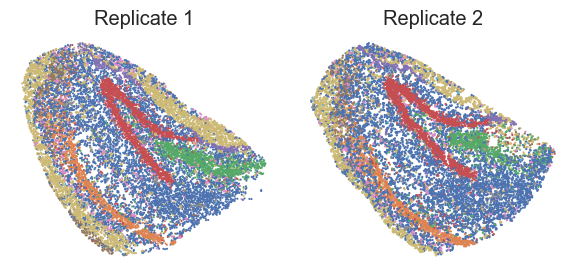

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
sc.pl.embedding(adata_list[0], basis="spatial", color="first_type", title="Replicate 1", show=False, ax=axes[0], frameon=False, legend_loc="none")
sc.pl.embedding(adata_list[1], basis="spatial", color="first_type", title="Replicate 2", show=False, ax=axes[1], frameon=False, legend_loc="none")
plt.tight_layout()

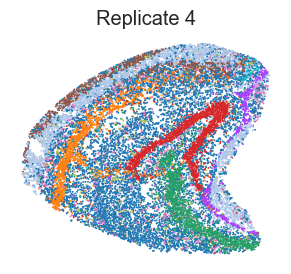

In [234]:
# save the two slice to disk
adata_slice4 = sc.read_h5ad(os.path.join(output_fmt.format(4), "adata_processed.h5ad"))
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
sc.pl.embedding(adata_slice4, basis="spatial", color="first_type", title="Replicate 4", show=True, frameon=False,
                ax=ax, legend_loc=None)

In [5]:
# construct the spatial network
adata_list = [sc.read_h5ad(os.path.join(output_dir, "adata_slice1.h5ad")),
              sc.read_h5ad(os.path.join(output_dir, "adata_slice2.h5ad"))]
adata_multi = sc.AnnData.concatenate(*adata_list, batch_key="replicate")
adata_multi = stutils.cal_spatial_net3D(adata_multi, iter_comb=None, batch_id="replicate", rad_cutoff=30,
                                add_key="spatial_net")
new_spatial = adata_multi.obsm["spatial"].copy()
new_spatial = stutils.quantize_coordination(new_spatial, methods=[("division", 60), ("division", 60)])
adata_multi.obsm["new_spatial"] = new_spatial

------Calculating spatial network for each batch...
Calculating spatial network for batch 0...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 78888 edges, 12918 cells, 6.1068 neighbors per cell on average.
Calculating spatial network for batch 1...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 62910 edges, 10998 cells, 5.7201 neighbors per cell on average.
------Calculating spatial bipartite network...
------Spatial network calculated.
Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.016666666666666666, mean deviation: 0.2507799134097571, pearson correlation: 0.9997683852286801
Quantize 1th dimension of spatial coordinates to 0.016666666666666666, mean deviation: 0.24873965287331729, pearson correlation: 0.9997052613724746


In [6]:
# save adata_multi to disk
adata_multi.write_h5ad(os.path.join(output_dir, "adata_multi.h5ad"))

In [220]:
# load adata_multi
adata_multi = sc.read_h5ad(os.path.join(output_dir, "adata_multi.h5ad"))
adata_multi.obs["replicate"].value_counts()

replicate
0    12918
1    10998
Name: count, dtype: int64

## Pretrain on each slice

In [122]:
n_epochs = 200
autoencoder = SpaAE(input_dim=adata_multi.shape[1],
                        block_list=["AttnBlock"],
                        gat_dim=[512, 32],
                        block_out_dims=[32, 32])
data = pipeline.prepare_dataset(adata_multi, use_net="spatial_net", use_spatial="new_spatial")
train_loaders = [get_slice_loader(adata_multi, data, batch, use_batch="replicate", batch_size=128) for batch in use_batches]

In [123]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs * len(train_loaders))
autoencoder.train()
autoencoder = autoencoder.to(device)
pbar = tqdm(range(n_epochs))
for epoch in pbar:
    for i, loader in enumerate(train_loaders):
        for batch_id, batch in enumerate(loader):
            batch = batch.to(device)
            optimizer.zero_grad()
            z, out = autoencoder(batch.x, batch.edge_index)
            loss = F.mse_loss(out, batch.x)
            loss.backward()
            optimizer.step()
            pbar.set_description("Epoch: {}, Batch: {}-{}, Loss: {:.4f}".format(epoch, i, batch_id, loss.item()))
            scheduler.step()
    scheduler.step()
    pbar.update(1)
# save the autoencoder
torch.save(autoencoder, os.path.join(output_dir, "autoencoder_attn2.pth"))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

<Axes: title={'center': 'Latent space'}, xlabel='UMAP1', ylabel='UMAP2'>

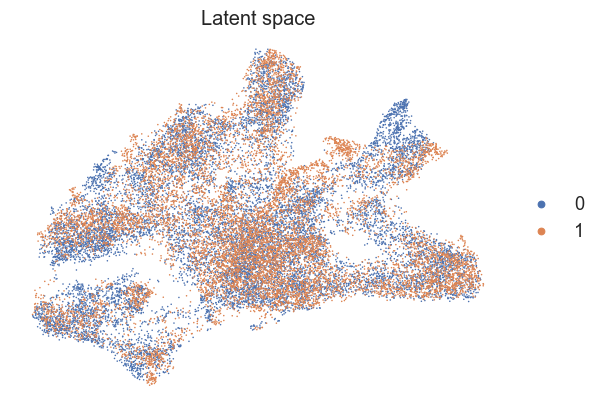

In [124]:
adata_temp = pipeline.get_recon(adata_multi.copy(), autoencoder, device=device, apply_normalize=False, show_progress=True, batch_mode=True)
sc.pp.neighbors(adata_temp, use_rep="latent", n_neighbors=30)
sc.tl.umap(adata_temp, min_dist=0.5)
sc.pl.umap(adata_temp, color="replicate", title="Latent space", show=False, frameon=False)

<Axes: title={'center': 'Latent space'}, xlabel='UMAP1', ylabel='UMAP2'>

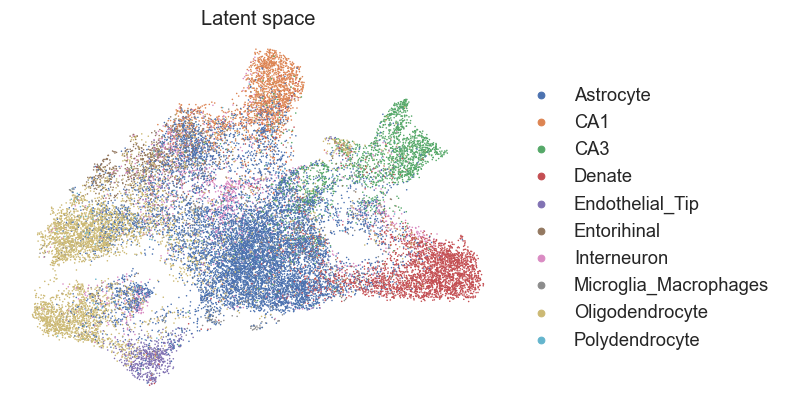

In [127]:
sc.pl.umap(adata_temp, color="first_type", title="Latent space", show=False, frameon=False)

<Axes: title={'center': 'Latent space'}, xlabel='UMAP1', ylabel='UMAP2'>

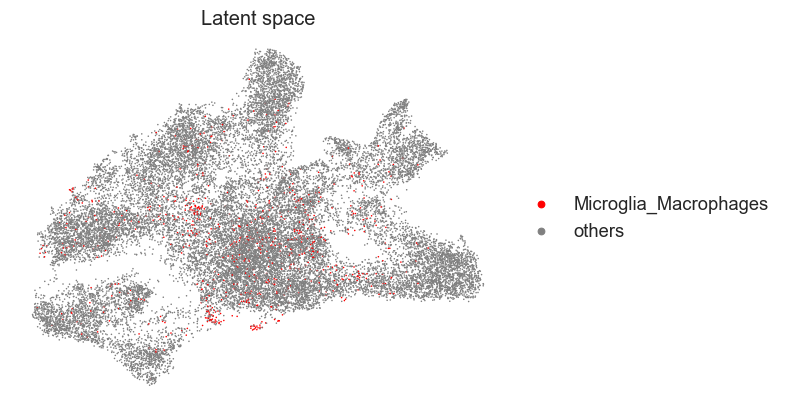

In [128]:
# show Microglia_Macrophages as red the others "first_type" as grey
adata_temp.obs["MM"] = "others"
adata_temp.obs.loc[adata_temp.obs["first_type"] == "Microglia_Macrophages", "MM"] = "Microglia_Macrophages"
sc.pl.umap(adata_temp, color="MM", title="Latent space", show=False, frameon=False,
           palette={"Microglia_Macrophages": "red", "others": "grey"})

## Align the latent space

In [132]:
train_loaders = []
index_mappings = []
iter_combs = [(i, i + 1) for i in range(len(use_batches) - 1)]
for batch_name in use_batches:
    num_spots = int((adata_multi.obs["replicate"] == batch_name).values.sum())
    loader = get_slice_loader(adata_multi, data, batch_name, use_batch="replicate", batch_size=num_spots)
    train_loaders.append(loader)
    batch = next(iter(loader))
    index_mappings.append({val.item(): idx for idx, val in enumerate(batch.n_id)})

In [65]:
output_fmt

'../output/App2-HPC/rep{}'

In [133]:
n_epochs = 400
pbar = tqdm(range(n_epochs))
# load the autoencoder

autoencoder = torch.load(os.path.join(output_dir, "..", "autoencoder_attn2.pth"))
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs * len(train_loaders))
triplet_loss = torch.nn.TripletMarginLoss(margin=1.0)
iter_comb =  [(i, i+1) for i in range(len(use_batches)-1)]
update_mn_eval = 50
autoencoder.train()
for epoch in range(1, n_epochs+1):
    if (epoch - 1) % update_mn_eval == 0:
        autoencoder.eval()
        adata_temp = pipeline.get_recon(adata_multi.copy(), autoencoder, device=device,
                           apply_normalize=False, show_progress=False, batch_mode=True)
        tri_samplers = []
        for (target_id, ref_id) in iter_comb:
            tri_samplers.append(TripletSampler(adata_temp, data, target=use_batches[target_id],
                                               use_rep="latent",
                                               reference=use_batches[ref_id],
                                               use_batch="replicate",
                                               num_neighbors=15))
    autoencoder.train()
    for ind, (target_id, ref_id) in enumerate(iter_comb):
        optimizer.zero_grad()
        target_batch = next(iter(train_loaders[target_id])).to(device)
        reference_batch = next(iter(train_loaders[ref_id])).to(device)
        z_target, out_target = autoencoder(target_batch.x, target_batch.edge_index)
        z_reference, out_reference = autoencoder(reference_batch.x, reference_batch.edge_index)
        anchor_indices, positive_indices, negative_indices = tri_samplers[ind].query(target_batch.n_id.detach().cpu().numpy())
        anchor_indices = [index_mappings[target_id][i] for i in anchor_indices]
        positive_indices =  [index_mappings[ref_id][i] for i in positive_indices]
        negative_indices = [index_mappings[target_id][i] for i in negative_indices]
        loss_rmse = F.mse_loss(out_target, target_batch.x) * .5 + F.mse_loss(out_reference, reference_batch.x) * .5
        z_a = z_target[anchor_indices]
        z_p = z_reference[positive_indices]
        z_n = z_target[negative_indices]
        loss_tri = triplet_loss(z_a, z_p, z_n)
        loss = loss_tri + loss_rmse
        loss.backward()
        torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), 5)
        optimizer.step()
        pbar.set_description(f"Epoch: {epoch}, Loss: {loss.item():.4f}")
    scheduler.step()
    pbar.update(1)
# save to autoencoder_aligned
torch.save(autoencoder, os.path.join(output_dir, "autoencoder_aligned.pth"))

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

<Axes: title={'center': 'Latent space'}, xlabel='UMAP1', ylabel='UMAP2'>

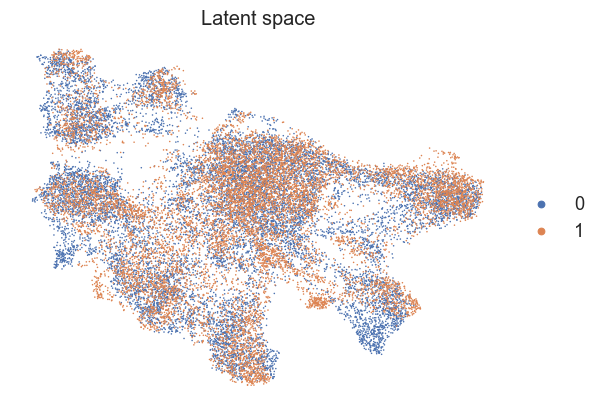

In [134]:
# perform the umap
autoencoder_multi = torch.load(os.path.join(output_dir, "..", "autoencoder_attn2.pth"))
adata_temp = pipeline.get_recon(adata_multi.copy(), autoencoder_multi, device=device, apply_normalize=False, show_progress=True, batch_mode=True)
sc.pp.neighbors(adata_temp, use_rep="latent", n_neighbors=30)
sc.tl.umap(adata_temp, min_dist=0.5)
sc.pl.umap(adata_temp, color="replicate", title="Latent space", show=False, frameon=False)

<Axes: title={'center': 'Latent space'}, xlabel='UMAP1', ylabel='UMAP2'>

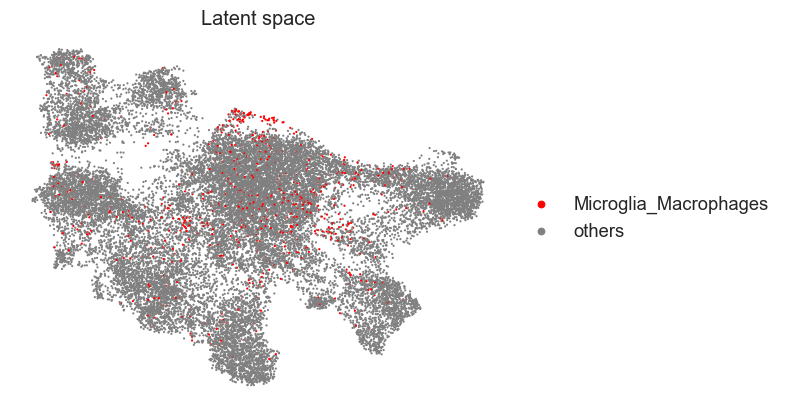

In [137]:
adata_temp.obs["MM"] = "others"
adata_temp.obs.loc[adata_temp.obs["first_type"] == "Microglia_Macrophages", "MM"] = "Microglia_Macrophages"

sc.pl.umap(adata_temp, color="MM", title="Latent space", show=False, frameon=False,
           palette={"Microglia_Macrophages": "red", "others": "grey"}, s=10)

<Axes: title={'center': 'Latent space'}, xlabel='UMAP1', ylabel='UMAP2'>

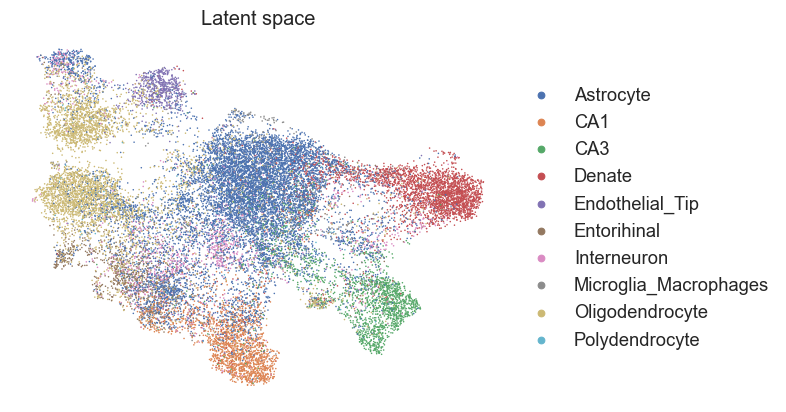

In [138]:
sc.pl.umap(adata_temp, color="first_type", title="Latent space", show=False, frameon=False)

In [116]:
output_dir = "../output/App2-HPC/"
autoencoder_full = torch.load(os.path.join(output_dir, "autoencoder_aligned.pth"))
rep_ids = [1, 2, 3, 4]
adata_list = [sc.read_h5ad(os.path.join(output_fmt.format(rep_id), "adata_processed.h5ad")) for rep_id in rep_ids]
adata_multi = sc.AnnData.concatenate(*adata_list, batch_key="replicate")
adata_multi = stutils.cal_spatial_net3D(adata_multi, iter_comb=None, batch_id="replicate", rad_cutoff=30,
                                add_key="spatial_net")

------Calculating spatial network for each batch...
Calculating spatial network for batch 0...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 78888 edges, 12918 cells, 6.1068 neighbors per cell on average.
Calculating spatial network for batch 1...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 62912 edges, 10998 cells, 5.7203 neighbors per cell on average.
Calculating spatial network for batch 2...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 91360 edges, 15397 cells, 5.9336 neighbors per cell on average.
Calculating spatial network for batch 3...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 106250 edges, 16800 cells, 6.3244 neighbors per cell on average.
------Calculating spatial bipartite network...
------Spatial network calculated.


In [111]:
adata_multi_recon = pipeline.get_recon(adata_multi.copy(), autoencoder, device=device, apply_normalize=False, show_progress=True,
                                       batch_mode=True)

  0%|          | 0/220 [00:00<?, ?it/s]

In [112]:
for target_cell_type in adata_multi_recon.obs["first_type"].unique():
    print("Perform DE on cell type: ", target_cell_type)
    cell_names = adata_multi_recon.obs_names[adata_multi_recon.obs["first_type"] == target_cell_type].tolist()
    # get the neigboring cells in the spatial network
    neighbors = adata_multi_recon.uns["spatial_net"]
    neighbors = neighbors[neighbors["Cell1"].isin(cell_names) | neighbors["Cell2"].isin(cell_names)]
    neighbors = set(neighbors.Cell1.tolist() + neighbors.Cell2.tolist())
    neighbors = list(neighbors - set(cell_names))
    # remove the duplicated cells in cell_names
    # set the cell names into three groups: cell_names, neighbors, and others
    adata_multi_recon.obs["cell_group"] = "others"
    adata_multi_recon.obs.loc[cell_names, "cell_group"] = target_cell_type
    adata_multi_recon.obs.loc[neighbors, "cell_group"] = target_cell_type + "_neighbors"
    sc.tl.rank_genes_groups(adata_multi_recon, groupby="cell_group", method="wilcoxon", reference=target_cell_type + "_neighbors")
    gene_list = sc.get.rank_genes_groups_df(adata_multi_recon, group=target_cell_type, key="rank_genes_groups", pval_cutoff=0.05).head(300).names.tolist()
    # save the gene list to disk
    gene_list_df = pd.DataFrame(gene_list, columns=["gene"])
    gene_list_df.to_csv(os.path.join(output_dir, "mul_deg", f"gene_list_{target_cell_type}.csv"), index=False)

Perform DE on cell type:  CA3
Perform DE on cell type:  CA1
Perform DE on cell type:  Denate
Perform DE on cell type:  Entorihinal
Perform DE on cell type:  Interneuron
Perform DE on cell type:  Astrocyte
Perform DE on cell type:  Endothelial_Tip
Perform DE on cell type:  Oligodendrocyte
Perform DE on cell type:  Microglia_Macrophages
Perform DE on cell type:  Polydendrocyte
Perform DE on cell type:  Neuron.Slc17a6


In [143]:
# laod autoencoder with 2 slices
output_dir = output_fmt.format("1_2")
autoencoder = torch.load(os.path.join(output_dir, "autoencoder_aligned.pth"))
adata_multi = sc.read_h5ad(os.path.join(output_dir, "adata_multi.h5ad"))
adata_mul_recon = pipeline.get_recon(adata_multi.copy(), autoencoder, device=device, apply_normalize=False, show_progress=True, batch_mode=True)

  0%|          | 0/94 [00:00<?, ?it/s]

In [147]:
for target_cell_type in adata_multi_recon.obs["first_type"].unique():
    print("Perform DE on cell type: ", target_cell_type)
    cell_names = adata_mul_recon.obs_names[adata_mul_recon.obs["first_type"] == target_cell_type].tolist()
    # get the neigboring cells in the spatial network
    neighbors = adata_mul_recon.uns["spatial_net"]
    neighbors = neighbors[neighbors["Cell1"].isin(cell_names) | neighbors["Cell2"].isin(cell_names)]
    neighbors = set(neighbors.Cell1.tolist() + neighbors.Cell2.tolist())
    neighbors = list(neighbors - set(cell_names))
    # remove the duplicated cells in cell_names
    # set the cell names into three groups: cell_names, neighbors, and others
    adata_mul_recon.obs["cell_group"] = "others"
    adata_mul_recon.obs.loc[cell_names, "cell_group"] = target_cell_type
    adata_mul_recon.obs.loc[neighbors, "cell_group"] = target_cell_type + "_neighbors"
    sc.tl.rank_genes_groups(adata_mul_recon, groupby="cell_group", method="wilcoxon", reference=target_cell_type + "_neighbors")
    gene_list = sc.get.rank_genes_groups_df(adata_mul_recon, group=target_cell_type, key="rank_genes_groups", pval_cutoff=0.05).head(300).names.tolist()
    # save the gene list to disk
    gene_list_df = pd.DataFrame(gene_list, columns=["gene"])
    gene_list_df.to_csv(os.path.join(output_dir, "mul_deg", f"gene_list_{target_cell_type}.csv"), index=False)
    # read the multi slice gene list
    gene_list_multi = pd.read_csv(os.path.join(output_dir, "..", "mul_deg", "gene_list_{}.csv".format(target_cell_type)), index_col=0)
    gene_list_multi = gene_list_multi.index.tolist()
    for n_top_genes in [100, 150, 200, 250, 300]:
        overlap = set(gene_list[:n_top_genes]).intersection(set(gene_list_multi[:n_top_genes]))
        print("Cell type: ", target_cell_type, "Overlap with multi: ", len(overlap), "/", n_top_genes)

Perform DE on cell type:  CA3
Cell type:  CA3 Overlap with multi:  79 / 100
Cell type:  CA3 Overlap with multi:  118 / 150
Cell type:  CA3 Overlap with multi:  154 / 200
Cell type:  CA3 Overlap with multi:  191 / 250
Cell type:  CA3 Overlap with multi:  239 / 300
Perform DE on cell type:  CA1
Cell type:  CA1 Overlap with multi:  76 / 100
Cell type:  CA1 Overlap with multi:  119 / 150
Cell type:  CA1 Overlap with multi:  161 / 200
Cell type:  CA1 Overlap with multi:  194 / 250
Cell type:  CA1 Overlap with multi:  244 / 300
Perform DE on cell type:  Denate
Cell type:  Denate Overlap with multi:  80 / 100
Cell type:  Denate Overlap with multi:  130 / 150
Cell type:  Denate Overlap with multi:  166 / 200
Cell type:  Denate Overlap with multi:  209 / 250
Cell type:  Denate Overlap with multi:  252 / 300
Perform DE on cell type:  Entorihinal
Cell type:  Entorihinal Overlap with multi:  56 / 100
Cell type:  Entorihinal Overlap with multi:  87 / 150
Cell type:  Entorihinal Overlap with multi: 

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:14                                                                                   │
│                                                                                                  │
│   11 │   adata_mul_recon.obs["cell_group"] = "others"                                            │
│   12 │   adata_mul_recon.obs.loc[cell_names, "cell_group"] = target_cell_type                    │
│   13 │   adata_mul_recon.obs.loc[neighbors, "cell_group"] = target_cell_type + "_neighbors"      │
│ ❱ 14 │   sc.tl.rank_genes_groups(adata_mul_recon, groupby="cell_group", method="wilcoxon", re    │
│   15 │   gene_list = sc.get.rank_genes_groups_df(adata_mul_recon, group=target_cell_type, key    │
│   16 │   # save the gene list to disk                                                            │
│   17 │   gene_list_df = pd.DataFrame(gene_list, columns=["gene"])                                │
│                                                                                                  │
│ C:\Users\001\anaconda3\envs\STADiffusion\lib\site-packages\scanpy\tools\_rank_genes_groups.py:57 │
│ 4 in rank_genes_groups                                                                           │
│                                                                                                  │
│   571 │   │   │   groups_order += [reference]                                                    │
│   572 │   if reference != 'rest' and reference not in adata.obs[groupby].cat.categories:         │
│   573 │   │   cats = adata.obs[groupby].cat.categories.tolist()                                  │
│ ❱ 574 │   │   raise ValueError(                                                                  │
│   575 │   │   │   f'reference = {reference} needs to be one of groupby = {cats}.'                │
│   576 │   │   )                                                                                  │
│   577                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: reference = Neuron.Slc17a6_neighbors needs to be one of groupby = ['others'].

In [139]:
# get the cell name in Microglia_Macrophages
cell_names = adata_temp.obs_names[adata_temp.obs["first_type"] == "Microglia_Macrophages"].tolist()
# get the neigboring cells in the spatial network
neighbors = adata_temp.uns["spatial_net"]
neighbors = neighbors[neighbors["Cell1"].isin(cell_names) | neighbors["Cell2"].isin(cell_names)]
neighbors = set(neighbors.Cell1.tolist() + neighbors.Cell2.tolist())
neighbors = neighbors - set(cell_names)
print("Number of MM cells: {} Number of neighbors: {}".format(len(cell_names), len(neighbors)))
# set the cell names into three groups: MM, neighbors, and others
adata_temp.obs["cell_group"] = "others"
adata_temp.obs.loc[cell_names, "cell_group"] = "MM"
adata_temp.obs.loc[list(neighbors), "cell_group"] = "neighbors"

Number of MM cells: 771 Number of neighbors: 2464


In [142]:
adata_temp_sub = adata_temp[adata_temp.obs["cell_group"] != "others", :]
sc.tl.rank_genes_groups(adata_temp_sub, groupby="cell_group", method="wilcoxon")
# get the top 100 genes
n_top_genes = 300
gene_list_2sclice = sc.get.rank_genes_groups_df(adata_temp_sub, group="MM", key="rank_genes_groups", pval_cutoff=0.05).head(n_top_genes).names.tolist()

In [149]:
gene_list_multi = pd.read_csv(os.path.join(output_dir, "..", "gene_list_multi.csv"), index_col=0)
gene_list_multi = gene_list_multi.index.to_list()
# compute the overlap
overlap = set(gene_list_2sclice[:200]).intersection(set(gene_list_multi[:200]))
len(overlap)

198

In [ ]:
# perform wilcoxon rank sum test
gene_list_enhanced = sc.get.rank_genes_groups_df(adata_real_recon, group="Microglia_Macrophages", key="rank_genes_groups", pval_cutoff=0.05).head(n_top_genes).names.tolist()
gene_list_raw = sc.get.rank_genes_groups_df(adata, group="Microglia_Macrophages",
                                            key="rank_genes_groups", pval_cutoff=0.05).head(n_top_genes).names.tolist()

In [31]:
# save gene_list_multi to disk
gene_list_multi_df = pd.DataFrame(gene_list_multi, columns=["gene"])
gene_list_multi_df.to_csv(os.path.join(output_dir, "..", "gene_list_multi.csv"), index=False)

### Generate sim data using the aligned autoencoder

In [74]:
# load denosier
output_dir = output_fmt.format("1_2")
adata_multi = sc.read_h5ad(os.path.join(output_dir, "adata_multi.h5ad"))
cond_name = "first_type"
n_rep = 5
num_class_embeds = len(np.unique(adata_multi.obs[cond_name]))
class_dict = dict(zip(np.unique(adata_multi.obs[cond_name]), range(num_class_embeds)))
denoiser = torch.load(os.path.join(output_dir, "denoiser_first_type.pth"))
autoencoder = torch.load(os.path.join(output_dir, "autoencoder_aligned.pth"))
adata_ = adata_multi[adata_multi.obs["replicate"] == "0"].copy()
new_spatial = adata_.obsm["new_spatial"].copy()
labels = adata_.obs[cond_name].map(class_dict).values.to_numpy()
adata_real_recon = pipeline.get_recon(adata_multi, autoencoder, device=device, use_net="spatial_net")
adata_real_recon = adata_real_recon[adata_real_recon.obs["replicate"] == "0"].copy()
normalizer = stutils.MinMaxNormalize(adata_real_recon.obsm["latent"], dim=0)
adata_ = stutils.cal_spatial_net2D(adata_, rad_cutoff=30, add_key="spatial_net")

------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 78888 edges, 12918 cells, 6.1068 neighbors per cell on average.


In [75]:
adata_real_recon

AnnData object with n_obs × n_vars = 12918 × 2455
    obs: 'spot_class', 'first_type', 'second_type', 'first_class', 'second_class', 'min_score', 'singlet_score', 'conv_all', 'conv_doublet', 'replicate'
    var: 'highly_variable', 'highly_variable_rank-0', 'means-0', 'variances-0', 'variances_norm-0', 'highly_variable_rank-1', 'means-1', 'variances-1', 'variances_norm-1'
    uns: 'spatial_net', 'log1p', 'edge_list'
    obsm: 'new_spatial', 'spatial', 'latent'

#### Generatte the simulated data

In [13]:
# generate the simulated data
data = pipeline.prepare_dataset(adata_, use_net="spatial_net", use_spatial="new_spatial")
n_rep = 5
for i in range(1, 1 + n_rep):
    stadiff_sim = pipeline.simulate(denoiser, autoencoder, device=device, use_net="spatial_net",
                                    ref_data=adata_, spatial_coord=new_spatial,
                                    labels = labels, seed=i, normarlizer=normalizer)
    stadiff_sim.write_h5ad("{}/stadiff_label_{}.h5ad".format(output_dir, i))

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
stadiff_sim.obsm["ori_spatial"] = adata_.obsm["spatial"].copy()

<Axes: title={'center': 'Simulated data'}, xlabel='ori_spatial1', ylabel='ori_spatial2'>

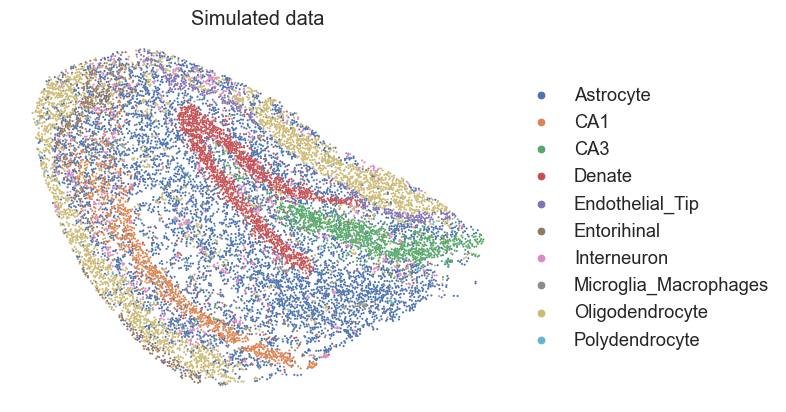

In [19]:
sc.pl.embedding(stadiff_sim, basis="ori_spatial", color=cond_name, title="Simulated data", show=False, frameon=False)

In [20]:
# load the simulated data to a list
stadiff_mul_list = [sc.read_h5ad("{}/stadiff_label_{}.h5ad".format(output_dir, i)) for i in range(1, 1 + n_rep)]

In [21]:
np.linalg.norm(stadiff_mul_list[0].X - stadiff_mul_list[1].X)

304.77713

In [33]:
single_output_dir = output_fmt.format("1")
# load to cpu
autoencoder_single = torch.load(os.path.join(single_output_dir, "autoencoder_attn2.pth"), map_location="cpu")
denoiser_single = torch.load(os.path.join(single_output_dir, "denoiser_first_type.pth"), map_location="cpu")
adata_rep1 = sc.read_h5ad(os.path.join(single_output_dir, "adata_processed.h5ad"))
adata_rep1_recon = pipeline.get_recon(adata_rep1, autoencoder_single, device="cuda:0", use_net="spatial_net", apply_normalize=False)
normalizer = stutils.MinMaxNormalize(adata_rep1_recon.obsm["latent"], dim=0)
new_spatial = adata_rep1.obsm["spatial"].copy()
new_spatial = stutils.quantize_coordination(new_spatial, methods=[("division", 60), ("division", 60)])
adata_rep1.obsm["new_spatial"] = new_spatial

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.016666666666666666, mean deviation: 0.25101163750838623, pearson correlation: 0.9997352469329742
Quantize 1th dimension of spatial coordinates to 0.016666666666666666, mean deviation: 0.24806613510863393, pearson correlation: 0.9997342240432965


In [35]:
# generate the simulated data
data = pipeline.prepare_dataset(adata_rep1, use_net="spatial_net", use_spatial="new_spatial")
for i in range(1, 1 + n_rep):
    stadiff_sim = pipeline.simulate(denoiser_single, autoencoder_single, device=device, use_net="spatial_net",
                                    ref_data=adata_rep1, spatial_coord=new_spatial,
                                    labels = labels, seed=i, normarlizer=normalizer)
    stadiff_sim.write_h5ad("{}/full_sim/stadiff_label_{}.h5ad".format(single_output_dir, i))

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
# load the simulated data to a list
stadiff_single_list = [sc.read_h5ad("{}/full_sim/stadiff_label_{}.h5ad".format(single_output_dir, i)) for i in range(1, 1 + n_rep)]

In [96]:
cell_type_names = adata_real_recon.obs["first_type"].unique().tolist()
# creat a text file "celltype_mul.txt" to store the resutls
f = open(os.path.join(output_dir, "..", "mul_deg", "celltype_mul.txt"), "w")
f.close()

In [99]:
os.path.join(output_dir, "..", "mul_deg", "celltype_mul.txt")

'../output/App2-HPC/rep1_2\\..\\mul_deg\\celltype_mul.txt'

In [102]:
# get the nieghbors of the Microglia_Macrophages
n_top_genes =100
for target_cell_type in cell_type_names:
    print("Perform DE on cell type: ", target_cell_type)
    with open(os.path.join(output_dir, "..", "mul_deg", "celltype_mul.txt"), "a") as f:
        f.write("Perform DE on cell type: {}\n".format(target_cell_type))
    cell_names =adata_real_recon.obs_names[adata_real_recon.obs["first_type"] == target_cell_type].tolist()
    neighbors = adata_real_recon.uns["spatial_net"]
    neighbors = neighbors[neighbors["Cell1"].isin(cell_names) | neighbors["Cell2"].isin(cell_names)]
    neighbors = set(neighbors.Cell1.tolist() + neighbors.Cell2.tolist())
    neighbors = neighbors - set(cell_names)
    print("Number of MM cells: {} Number of neighbors: {}".format(len(cell_names), len(neighbors)))
    # set the cell names into three groups: MM, neighbors, and others
    adata_real_recon.obs["cell_group"] = "others"
    adata_real_recon.obs.loc[cell_names, "cell_group"] = "MM"
    adata_real_recon.obs.loc[list(neighbors), "cell_group"] = "MM_neighbors"
    # compute the overlap between enhanced and method gene
    use_rep_n = 1
    gene_sim_mul_list = []
    for i in range(1, 1 + n_rep):
        print("Use {} simulated replicate".format(i))
        use_ad_list = stadiff_mul_list[:i]
        for ad in use_ad_list:
            ad.obs["cell_group"] = adata_real_recon.obs["cell_group"].copy()
            ad = ad[ad.obs["cell_group"].isin(["MM", "MM_neighbors"]), :].copy()
        adata_sim_recon = sc.AnnData.concatenate(*use_ad_list, batch_key="replicate")
        sc.tl.rank_genes_groups(adata_sim_recon, groupby="cell_group", method="wilcoxon", reference="MM_neighbors")
        gene_sim_mul = sc.get.rank_genes_groups_df(adata_sim_recon, group="MM", key="rank_genes_groups", pval_cutoff=0.1).head(300).names.tolist()
        gene_sim_mul_list.append(gene_sim_mul)
    gene_list_multi = pd.read_csv(os.path.join(output_dir, "..", "mul_deg", "gene_list_{}.csv".format(target_cell_type)), index_col=0)
    gene_list_multi = gene_list_multi.index.tolist()
    for n_top_genes in [100, 150, 250, 300]:
        for i in range(1, 1 + n_rep):
            overlap = set(gene_sim_mul_list[i-1][:n_top_genes]).intersection(set(gene_list_multi[:n_top_genes]))
            print("Overlap with {} simulated data: {}/{}".format(i, len(overlap), n_top_genes))
            with open(os.path.join(output_dir, "..", "mul_deg", "celltype_mul.txt"), "a") as f:
                f.write("Overlap with {} simulated data: {}/{}\n".format(i, len(overlap), n_top_genes))
        with open(os.path.join(output_dir, "..", "mul_deg", "celltype_mul.txt"), "a") as f:
            f.write("----------------------------------------------\n")
    with open(os.path.join(output_dir, "..", "mul_deg", "celltype_mul.txt"), "a") as f:
        f.write("==============================================\n")

Perform DE on cell type:  CA3
Number of MM cells: 1042 Number of neighbors: 711
Use 1 simulated replicate
Use 2 simulated replicate
Use 3 simulated replicate
Use 4 simulated replicate
Use 5 simulated replicate
Overlap with 1 simulated data: 71/100
Overlap with 2 simulated data: 69/100
Overlap with 3 simulated data: 70/100
Overlap with 4 simulated data: 71/100
Overlap with 5 simulated data: 69/100
Overlap with 1 simulated data: 106/150
Overlap with 2 simulated data: 104/150
Overlap with 3 simulated data: 106/150
Overlap with 4 simulated data: 105/150
Overlap with 5 simulated data: 106/150
Overlap with 1 simulated data: 173/250
Overlap with 2 simulated data: 174/250
Overlap with 3 simulated data: 174/250
Overlap with 4 simulated data: 175/250
Overlap with 5 simulated data: 174/250
Overlap with 1 simulated data: 219/300
Overlap with 2 simulated data: 218/300
Overlap with 3 simulated data: 219/300
Overlap with 4 simulated data: 220/300
Overlap with 5 simulated data: 221/300
Perform DE on c

## Go enrichment analysis

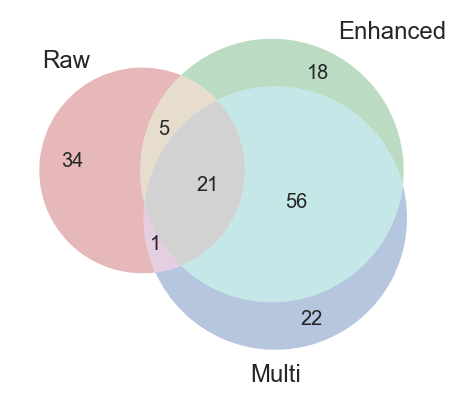

In [368]:
from matplotlib_venn import venn3
from scanpy.plotting.palettes import vega_20_scanpy
venn3([set(gene_list_raw), set(gene_list_enhanced), set(gene_list_multi)], set_labels=["Raw", "Enhanced", "Multi"])

['synapse', 'synapse organization', 'nervous system development', 'cell junction organization', 'cell junction', 'anatomical structure development', 'somatodendritic compartment', 'cell body', 'neurogenesis', 'system development', 'developmental process', 'postsynapse', 'multicellular organism development', 'neuron projection', 'microglial cell activation', 'cellular component organization', 'leukocyte activation involved in inflammatory response', 'positive regulation of biological process', 'cellular component organization or biogenesis', 'glial cell activation']


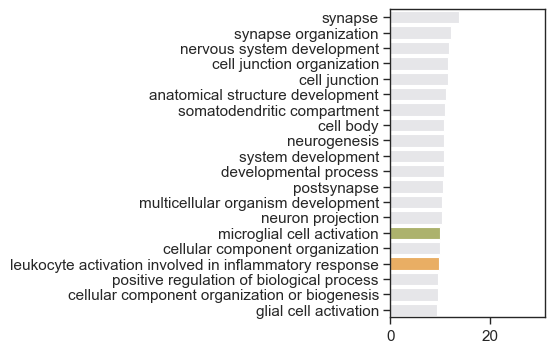

In [152]:
from scanpy.plotting.palettes import vega_20_scanpy
sns.set_theme("paper", style="ticks", font_scale=1.25)
yellow = "#FFB14E"
purple = "#9D02D7"
n_terms = 20
microglia_color = vega_20_scanpy[7]
unknown_color = "#E5E5E9"
palette_pattern = {"immune": yellow, "immune": yellow, "inflammatory": yellow, "cytokine": yellow,
                   "leukocyte": yellow, "stimulus": yellow, "defense": yellow,
                   "phagocytosis": yellow, "microglia": microglia_color}
go_raw = go_res_dict["raw"]
gp = go_plot_palette(go_raw, palette_pattern, unknown_color=unknown_color)
figsize = (2, 4)
fig, ax = plt.subplots(1, 1, figsize=figsize)
go_raw["log_pval"] = -np.log10(go_raw["p_value"])
# plot dot plot with go_palette horizontally
sns.barplot(data=go_raw.head(n_terms), y="name", x="log_pval", ax=ax, palette=gp,
            orient="h")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("")
ax.set_xlim(0, 31)

In [154]:
go_df = go_res_dict["enhanced"]
top_term_names = go_df.head(n_terms).name.tolist()
for name in top_term_names:
    print(name)

immune system process
cell activation
regulation of response to stimulus
regulation of multicellular organismal process
immune response
protein binding
regulation of immune system process
defense response
response to external stimulus
response to stimulus
positive regulation of response to stimulus
positive regulation of biological process
response to biotic stimulus
inflammatory response
response to other organism
response to external biotic stimulus
response to stress
cell periphery
biological process involved in interspecies interaction between organisms
positive regulation of cellular process


immune system process
immune response
cell activation
regulation of immune system process
defense response
positive regulation of immune system process
inflammatory response
response to biotic stimulus
Tyrobp causal network in microglia
positive regulation of biological process
defense response to symbiont
response to external stimulus
immune effector process
Microglia pathogen phagocytosis pathway
defense response to other organism
Innate Immune System
regulation of cytokine production
cytokine production
regulation of multicellular organismal process
response to other organism


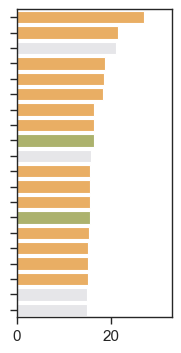

In [168]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
go_enhanced = go_res_dict["enhanced"]
go_enhanced["log_pval"] = -np.log10(go_enhanced["p_value"])
# plot dot plot with go_palette horizontally
gp = go_plot_palette(go_enhanced, palette_pattern, unknown_color=unknown_color)
sns.barplot(data=go_enhanced.head(n_terms), y="name", x="log_pval", ax=ax, palette=gp,
            orient="h")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("")
ax.set_yticklabels([])
ax.set_xlim(0, 33)
for name in go_enhanced.head(n_terms).name.tolist():
    print(name)

In [170]:
go_res_dict["multi"] = sc.queries.enrich(gene_list_multi[:100], org="mmusculus")

immune system process
immune response
regulation of immune system process
response to biotic stimulus
cell activation
defense response
response to other organism
response to external biotic stimulus
immune effector process
biological process involved in interspecies interaction between organisms
response to external stimulus
defense response to symbiont
Microglia pathogen phagocytosis pathway
defense response to other organism
positive regulation of immune system process
innate immune response
leukocyte activation
positive regulation of response to stimulus
inflammatory response
regulation of immune response


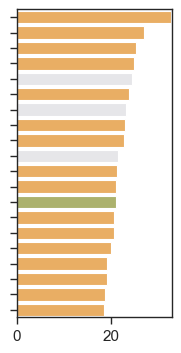

In [172]:
go_multi = go_res_dict["multi"]
fig, ax = plt.subplots(1, 1, figsize=figsize)
go_multi["log_pval"] = -np.log10(go_multi["p_value"])
# plot dot plot with go_palette horizontally
gp = go_plot_palette(go_multi, palette_pattern, unknown_color=unknown_color)
sns.barplot(data=go_multi.head(n_terms), y="name", x="log_pval", ax=ax, palette=gp,
            orient="h")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("")
ax.set_yticklabels([])
ax.set_xlim(0, 33)
for name in go_multi.head(n_terms).name.tolist():
    print(name)

In [458]:
go_multi_immune = go_multi[go_multi["name"].str.contains("immune", case=False)]
go_enhanced_immune = go_enhanced[go_enhanced["name"].str.contains("immune", case=False)]
# mathcing the two df by name
go_match_immune = go_multi_immune.merge(go_enhanced_immune, on="name", how="outer")
go_match_immune = go_match_immune.fillna(0)
go_match_sub_immune = go_match_immune[["log_pval_x", "log_pval_y", "name"]]
go_match_sub_immune["diff"] = go_match_sub_immune["log_pval_x"] - go_match_sub_immune["log_pval_y"]
go_match_sub_immune

log_pval_x  log_pval_y                                               name  \
0    30.549423   26.389952                              immune system process   
1    28.305000   22.925479                                    immune response   
2    23.063017   17.870022                regulation of immune system process   
3    21.594583   15.758237                            immune effector process   
4    18.360153   17.431115       positive regulation of immune system process   
5    16.591304   15.649744                             innate immune response   
6    16.300954   13.172486                      regulation of immune response   
7    15.631032    9.181055   leukocyte activation involved in immune response   
8    15.551726    9.123058        cell activation involved in immune response   
9    13.125246    7.351880              regulation of immune effector process   
10   12.929378   11.965516             positive regulation of immune response   
11   12.820333   10.669792                           adaptive immune response   
12   12.253199   13.193024                               Innate Immune System   
13   10.179410    7.049427       negative regulation of immune system process   
14    9.387267    3.624019  myeloid cell activation involved in immune res...   
15    9.311143    7.171995  adaptive immune response based on somatic reco...   
16    9.171733    9.271912                      activation of immune response   
17    9.080882    8.057691       immune response-regulating signaling pathway   
18    8.715910    9.936481                                      Immune System   
19    8.555468    3.958549     positive regulation of immune effector process   
20    8.313182    7.332676                  Abnormal immune system morphology   
21    7.720419    6.760690         Abnormal cellular immune system morphology   
22    7.404695    4.991732  lymphocyte activation involved in immune response   
23    7.274355    2.862303  immune response-regulating cell surface recept...   
24    7.087266    7.171995       immune response-activating signaling pathway   
25    6.355693    3.053812  immune response-activating cell surface recept...   
26    5.891898    3.150393  microglial cell activation involved in immune ...   
27    5.856072    4.542524      T cell activation involved in immune response   
28    5.076131    1.481015     negative regulation of immune effector process   
29    4.820503    2.613862             regulation of adaptive immune response   
30    4.665690    2.780844  macrophage activation involved in immune response   
31    4.346118    0.000000  humoral immune response mediated by circulatin...   
32    4.071004    0.000000            immunoglobulin mediated immune response   
33    3.915471    1.752705  regulation of adaptive immune response based o...   
34    3.847001    0.000000             negative regulation of immune response   
35    3.846639    4.892184               regulation of innate immune response   
36    3.584167    2.322593                           immune receptor activity   
37    3.505369    2.764516                   Abnormality of the immune system   
38    3.126830    2.439995            Abnormality of immune system physiology   
39    2.922996    0.000000  neutrophil activation involved in immune response   
40    2.826402    0.000000  regulation of immunoglobulin mediated immune r...   
41    2.721344    2.776659                            humoral immune response   
42    2.644246    1.528188    positive regulation of adaptive immune response   
43    2.498097    2.545304  positive regulation of production of molecular...   
44    2.000087    0.000000  positive regulation of immunoglobulin mediated...   
45    1.806619    5.840887      positive regulation of innate immune response   
46    1.603410    1.649777  regulation of production of molecular mediator...   
47    1.599768    0.000000  positive regulation of adaptive immune respons...   
48    1.425758    0.000000         

In [460]:
go_multi_microglia = go_multi[go_multi["name"].str.contains("microglia", case=False)]
go_enhanced_microglia = go_enhanced[go_enhanced["name"].str.contains("microglia", case=False)]
# mathcing the two df by name
print(go_multi_microglia.shape, go_enhanced_microglia.shape)
go_match_microglia = go_multi_microglia.merge(go_enhanced_microglia, on="name", how="outer")
go_match_microglia = go_match_microglia.fillna(0)
go_match_sub_microglia = go_match_microglia[["log_pval_x", "log_pval_y", "name"]]
go_match_sub_microglia["diff"] = go_match_sub_microglia["log_pval_x"] - go_match_sub_microglia["log_pval_y"]
go_match_sub_microglia
# replace na with 0

(9, 15) (7, 15)


log_pval_x  log_pval_y                                               name  \
0   20.333224   15.481825            Microglia pathogen phagocytosis pathway   
1   14.095044   16.263851                 Tyrobp causal network in microglia   
2    6.352103    6.400955                         microglial cell activation   
3    5.891898    3.150393  microglial cell activation involved in immune ...   
4    3.517375    0.000000  regulation of microglial cell mediated cytotox...   
5    3.517375    0.000000              microglial cell mediated cytotoxicity   
6    2.820607    2.850452   positive regulation of microglial cell migration   
7    2.578670    2.608503                          microglial cell migration   
8    2.578670    2.608503            regulation of microglial cell migration   

       diff  
0  4.851399  
1 -2.168807  
2 -0.048852  
3  2.741505  
4  3.517375  
5  3.517375  
6 -0.029844  
7 -0.029832  
8 -0.029832

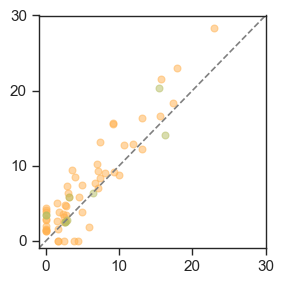

In [470]:
# plot log_pval_x vs log_pval_y
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(go_match_sub_immune["log_pval_y"], go_match_sub_immune["log_pval_x"],
           s=25, c=yellow, alpha=0.5)
ax.scatter(go_match_sub_microglia["log_pval_y"], go_match_sub_microglia["log_pval_x"], s=25,
           c=vega_20_scanpy[7], alpha=0.5)

ax.set_ylabel("")
ax.set_xlabel("")
# plot the diagonal line
# get the x and y limits
# plot a diagonal line
ax.set_xlim(-1, 30)
ax.set_ylim(-1, 30)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color="grey", linestyle="--")
ax.plot()
ax.set_xticks([0, 10, 20, 30])
ax.set_yticks([0, 10, 20, 30])
plt.tight_layout()

In [472]:
# perform the wilcoxon rank sum test
# combine go_match_sub_immune and go_match_sub_microglia
go_match_sub = pd.concat([go_match_sub_immune, go_match_sub_microglia], axis=0)
# perform log_pval_x vs log_pval_y
scipy.stats.wilcoxon(go_match_sub["log_pval_x"], go_match_sub["log_pval_y"])

WilcoxonResult(statistic=385.0, pvalue=7.028739662976453e-06)

## In silico differential expression analysis
- Simulate with labels has more overlap DE genes than that not using labels.
- In-place generation, the overlap genes will stop after using 2 replications.

In [473]:
# read stadiff
stadiff_sim_list = [sc.read_h5ad("{}/stadiff_{}.h5ad".format(output_dir, i)) for i in range(1, 1 + n_rep)]
stadiff_sim_label_list = [sc.read_h5ad("{}/stadiff_label_{}.h5ad".format(output_dir, i)) for i in range(1, 1 + n_rep)]

In [487]:
cell_names = adata[adata.obs["first_type"] == "Microglia_Macrophages"].obs_names.tolist()
# get the neigboring cells in the spatial network
neighbors = adata.uns["spatial_net"]
neighbors = neighbors[neighbors["Cell1"].isin(cell_names) | neighbors["Cell2"].isin(cell_names)]
neighbors = set(neighbors.Cell1.tolist() + neighbors.Cell2.tolist())
neighbors = neighbors - set(cell_names)
cell_group = adata.obs["cell_group"].copy()
print("Number of MM cells: {} Number of neighbors: {}".format(len(cell_names), len(neighbors)))

Number of MM cells: 470 Number of neighbors: 1380


In [491]:
# perform the wilcoxon rank sum test
ind = 0
n_top_genes = 100
sim_ad = stadiff_sim_list[ind]
sim_ad.uns["log1p"]["base"] = np.e
sim_ad.obs["cell_group"] = cell_group
sc.tl.rank_genes_groups(sim_ad, groupby="cell_group", method="wilcoxon")
gene_list_sim = sc.get.rank_genes_groups_df(sim_ad, group="Microglia_Macrophages",
                                            key="rank_genes_groups", pval_cutoff=0.05).head(n_top_genes).names.tolist()
# get the top 100 genes
sim_label_ad = stadiff_sim_label_list[ind]
sim_label_ad.uns["log1p"]["base"] = np.e
sim_label_ad.obs["cell_group"] = cell_group
sc.tl.rank_genes_groups(sim_label_ad, groupby="cell_group", method="wilcoxon")
gene_list_sim_label = sc.get.rank_genes_groups_df(sim_label_ad, group="Microglia_Macrophages",
                                            key="rank_genes_groups", pval_cutoff=0.05).head(n_top_genes).names.tolist()

In [563]:
gene_list_sim_dict = dict()
n_top_genes = 300
for k in range(1, 6):
    print("Use {} replications".format(k))
    # use k replications
    if k == 1:
        ad_temp = stadiff_sim_list[0]
        ad_temp.obs["cell_group"] = cell_group
    else:
        ad_temp = []
        for i in range(k):
            ad = stadiff_sim_label_list[i]
            ad.obs["cell_group"] = cell_group
            ad_temp.append(ad)
        ad_temp = sc.AnnData.concatenate(*ad_temp, batch_key="replicate")
    sc.tl.rank_genes_groups(ad_temp, groupby="cell_group", method="wilcoxon")
    gene_list_sim_dict[k] = sc.get.rank_genes_groups_df(ad_temp, group="Microglia_Macrophages",
                                            key="rank_genes_groups", pval_cutoff=0.05).head(n_top_genes).names.tolist()

Use 1 replications
Use 2 replications
Use 3 replications
Use 4 replications
Use 5 replications


In [587]:
# cmpute the mean of 5 replications
X = 0
for i in range(5):
    X += stadiff_sim_label_list[i].X
X /= 5
ad_temp = stadiff_sim_label_list[0].copy()
ad_temp.X = X
ad_temp.obs["cell_group"] = cell_group
sc.tl.rank_genes_groups(ad_temp, groupby="cell_group", method="wilcoxon")
gene_list_mean = sc.get.rank_genes_groups_df(ad_temp, group="Microglia_Macrophages",
                                            key="rank_genes_groups", pval_cutoff=0.05).head(n_top_genes).names.tolist()

In [592]:
for used_gene in [100, 150, 200, 250, 300]:
    print("Use {} genes".format(used_gene))
    print("Overlap with enhanced", len(set(gene_list_mean[:used_gene]).intersection(set(gene_list_enhanced[:used_gene]))))
    print("Overlap with multi", len(set(gene_list_mean[:used_gene]).intersection(set(gene_list_multi[:used_gene]))))

Use 100 genes
Overlap with enhanced 96
Overlap with multi 76
Use 150 genes
Overlap with enhanced 142
Overlap with multi 120
Use 200 genes
Overlap with enhanced 186
Overlap with multi 155
Use 250 genes
Overlap with enhanced 225
Overlap with multi 184
Use 300 genes
Overlap with enhanced 274
Overlap with multi 214


In [566]:
used_genes = [100, 150, 200, 250, 300]
overlap_dict = dict()
for n_genes in used_genes:
    overlap_dict[str(n_genes) + "_enhanced"] = []
    overlap_dict[str(n_genes) + "_multi"] = []
    for k, gene_list in gene_list_sim_dict.items():
        overlap_dict[str(n_genes) + "_enhanced"].append(len(set(gene_list[:n_genes]).intersection(set(gene_list_enhanced[:n_genes]))))
        overlap_dict[str(n_genes) + "_multi"].append(len(set(gene_list[:n_genes]).intersection(set(gene_list_multi[:n_genes]))))

In [585]:
for used_gene in used_genes:
    print("Use {} genes".format(used_gene))
    print("Overlap with enhanced", overlap_dict[str(used_gene) + "_enhanced"])
    print("Overlap with multi", overlap_dict[str(used_gene) + "_multi"])

Use 100 genes
Overlap with enhanced [89, 95, 95, 95, 95]
Overlap with multi [72, 76, 76, 76, 76]
Use 150 genes
Overlap with enhanced [131, 141, 142, 142, 142]
Overlap with multi [109, 119, 120, 120, 120]
Use 200 genes
Overlap with enhanced [167, 184, 184, 184, 185]
Overlap with multi [141, 153, 153, 153, 153]
Use 250 genes
Overlap with enhanced [210, 224, 224, 224, 225]
Overlap with multi [173, 183, 183, 183, 183]
Use 300 genes
Overlap with enhanced [257, 273, 273, 272, 273]
Overlap with multi [200, 212, 212, 213, 214]


In [586]:
# compute the overlap of enhanced and multi varying the number of genes
for used_gene in used_genes:
    print("Use {} genes".format(used_gene))
    print("Overlap between enhanced and multi", len(set(gene_list_enhanced[:used_gene]).intersection(set(gene_list_multi[:used_gene]))))

Use 100 genes
Overlap between enhanced and multi 77
Use 150 genes
Overlap between enhanced and multi 119
Use 200 genes
Overlap between enhanced and multi 160
Use 250 genes
Overlap between enhanced and multi 193
Use 300 genes
Overlap between enhanced and multi 218


In [658]:
gene_list_sim_each = []
for i in range(5):
    ad_temp = stadiff_sim_label_list[i].copy()
    ad_temp.obs["cell_group"] = cell_group
    sc.tl.rank_genes_groups(ad_temp, groupby="cell_group", method="wilcoxon")
    gene_list_sim_each.append(sc.get.rank_genes_groups_df(ad_temp, group="Microglia_Macrophages",
                                            key="rank_genes_groups", pval_cutoff=0.05).head(n_top_genes).names.tolist())

In [657]:
# compute how many times the gene appear in the 5 replications
gene_count = dict()
for gene_list in gene_list_sim_each:
    for gene in gene_list:
        if gene in gene_count:
            gene_count[gene] += 1
        else:
            gene_count[gene] = 1
gene_count_df = pd.DataFrame(gene_count.items(), columns=["gene", "count"])
gene_count_df

gene  count
0    Slc2a5      5
1      Cd53      5
2    Ptpn18      5
3    Inpp5d      5
4     Gna15      5
..      ...    ...
304   Snx18      2
305     Aga      2
306  Hibadh      2
307     Oaf      1
308   Mertk      1

[309 rows x 2 columns]

In [637]:
# generate simualted data with spatial coordinates permutation
new_spatial = adata.obsm["spatial"].copy()
new_spatial_df = pd.DataFrame(new_spatial, columns=["x", "y"], index=adata.obs_names)
# get the MM cell spatial coordinates
mm_spatial = new_spatial_df.loc[cell_names]
spatial_net = adata.uns["spatial_net"].copy()
# get the neighboring cells of MM cells
neighbors = spatial_net[spatial_net["Cell1"].isin(cell_names) & spatial_net["Cell2"].isin(cell_names)]
# add new points between the MM cells
up_scale_ratio = 1.5
n_new_spots = int(len(cell_names) * (up_scale_ratio - 1))
# random choose n row indices from net
np.random.seed(2024)
indices = np.random.choice(neighbors.shape[0], n_new_spots)
select_cells = neighbors.iloc[indices, :]
# compute the new points as the middle point of the two points
start_points = mm_spatial.loc[select_cells["Cell1"]].values
end_points = mm_spatial.loc[select_cells["Cell2"]].values
new_points = (start_points + end_points) / 2
# add the new points to the spatial
new_spatial = np.vstack((new_spatial, new_points))
# add the new labels to the first_type
new_labels = ["Microglia_Macrophages"] * n_new_spots
# add the new labels to the first_type
new_first_type = adata.obs["first_type"].values.tolist() + new_labels
adata_upsample = sc.AnnData(X=np.zeros([adata.X.shape[0] + n_new_spots, adata.X.shape[1]]))
adata_upsample.obsm["spatial"] = new_spatial

In [638]:
# quantize the new spatial
new_spatial = stutils.quantize_coordination(new_spatial, methods=[("division", 60), ("division", 60)])
adata_upsample.obsm["new_spatial"] = new_spatial
new_first_type = [class_dict[i] for i in new_first_type]
new_first_type = np.array(new_first_type)
# find 2d spatial network
adata_upsample = stutils.cal_spatial_net2D(adata_upsample, rad_cutoff=30, add_key="spatial_net")

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.016666666666666666, mean deviation: 0.2497519511258956, pearson correlation: 0.9998519507292156
Quantize 1th dimension of spatial coordinates to 0.016666666666666666, mean deviation: 0.25059951808256564, pearson correlation: 0.9997687191328812
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 95722 edges, 15632 cells, 6.1235 neighbors per cell on average.


In [639]:
data = pipeline.prepare_dataset(adata_upsample, use_net="spatial_net", use_spatial="new_spatial")

In [640]:
stadiff_upsample = pipeline.simulate(denoiser=denoiser_label, autoencoder=autoencoder, ref_data=adata_upsample,
                                     spatial_coord=new_spatial, labels=new_first_type, device=device)
cell_group_upsample = adata.obs["cell_group"].copy().tolist()
cell_group_upsample += ["Microglia_Macrophages"] * n_new_spots
stadiff_upsample.obs["cell_group"] = cell_group_upsample

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

In [649]:
stadiff_upsample.var_names = adata.var_names

In [650]:
# perform the wilcoxon rank sum test
sc.tl.rank_genes_groups(stadiff_upsample, groupby="cell_group", method="wilcoxon")
gene_list_upsample = sc.get.rank_genes_groups_df(stadiff_upsample, group="Microglia_Macrophages",
                                            key="rank_genes_groups", pval_cutoff=0.05).head(n_top_genes).names.tolist()


In [651]:
for used_gene in [100, 150, 200, 250, 300]:
    print("Use {} genes".format(used_gene))
    print("Overlap with enhanced", len(set(gene_list_upsample[:used_gene]).intersection(set(gene_list_enhanced[:used_gene]))))
    print("Overlap with multi", len(set(gene_list_upsample[:used_gene]).intersection(set(gene_list_multi[:used_gene]))))

Use 100 genes
Overlap with enhanced 0
Overlap with multi 1
Use 150 genes
Overlap with enhanced 6
Overlap with multi 2
Use 200 genes
Overlap with enhanced 14
Overlap with multi 15
Use 250 genes
Overlap with enhanced 19
Overlap with multi 22
Use 300 genes
Overlap with enhanced 40
Overlap with multi 44


In [577]:
# compute pairwise distance
from itertools import combinations
norm_diff_mat = np.zeros((len(stadiff_sim_label_list), len(stadiff_sim_label_list)))
for i, j in combinations(range(len(stadiff_sim_label_list)), 2):
    norm_diff_mat[i, j] = np.linalg.norm(stadiff_sim_label_list[i].X - stadiff_sim_label_list[j].X)
    norm_diff_mat[j, i] = norm_diff_mat[i, j]